# Plotting cross section ratios as a function of Bjorken-x

<h2 style="text-align: center; color: orange">EMC ratios fitted till x = 0.6 until stated otherwise</h2>

In [1]:
fit_lo = 0.3
fit_high = 0.7

# Which xsec model are you probing
# xsec_tables = 'xsec_tables' 
xsec_tables = 'xsec_tables_outv2'

if fit_high == 0.6 and xsec_tables == 'xsec_tables':
    folder = 'inelastic'
elif fit_high == 0.6 and xsec_tables == 'xsec_tables_outv2':
    folder = 'old'
elif fit_high == 0.7 and xsec_tables == 'xsec_tables':
    folder = 'xp7/v4'
elif fit_high == 0.7 and xsec_tables == 'xsec_tables_outv2':
    folder = 'xp7/v2'
else:
    sys.exit('Terminating due to invalid fit range or model')

import uproot, time, sys
start_time = time.time()
sys.path.append('/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2')
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy import stats
from common_functions import read_report, ImportRadcor, target_info, root_hist_to_numpy, csb, jra_nprat, datahist_from_array, mchist_from_array, cereff, baja, E, leaky_cauldron
from common_functions import LD2_dict, C12_dict, Dummy_dict, Fe54_dict, Ca40_dict, Be9_dict, Ca48_dict, B10_dict, B11_dict, He4_dict, He3_dict, C12_dict_l2, delta_correction
from common_functions import Sn119_dict, Ti48_dict, Ag108_dict, Th232_dict, Ni58_dict, Ni64_dict, Li7_dict, Li6_dict, Al27_dict, Cu63_dict, Au197_dict, cafe_report_path, tinfo_path

\begin{equation}
    \sigma^{Born}_{data} = \frac{Y_{data}}{Y_{MC}} \cdot \sigma^{Born}_{Model}
\end{equation}

In [2]:
ntg = 'C12' # What is the nuclei in numerator?

In [3]:
# Parameters
ntg = "Ag108"


In [4]:
leaky = 0 # 1 for leaky cauldron, 0 for regular
nsimstring = ntg.lower()
print("nsimstring", nsimstring)
dtg = 'LD2' # What is the nuclei in denominator?
dsimstring = dtg.lower()
print("dsimstring", dsimstring)
ald = 'Dummy' # Aluminium dummy target
dang = 20.0 # What is your desired angle?
dmom = [2.42, 2.71, 3.04, 3.40, 3.81, 4.27, 4.78, 5.36, 5.878, 6.6] # What are your desired central momenta (just the magnitude)
bin_per_mom = 32 # How many bins per momentum?
C = 0
bin_num = bin_per_mom * len(dmom) # Total number of bins in the combined histogram

# Kinematic variables
ts, idang = dang, int(dang) # Spectrometer angle
Z, A = target_info[ntg][0], target_info[ntg][1]  # Target
thick = target_info[ntg][2] # g/cm2. From Cameron's target sheet column 'R'
ep_min = {}
ep_max = {}

# Constants
Ei, Mp = 10.54, 0.93825 # Beam energcountsy and proton mass in GeV
N_A, Q_E = 6.02e+23, 1.60e-19 # Avogadro's number and charge in 1 electron
dpp_up, dpp_down = 10.0, -10.0 # Momentum acceptance upper and lower limit
cos_ts = np.cos(np.deg2rad(ts))
sin_ts = np.sin(np.deg2rad(ts))

for momentum in dmom:
    ep_min[momentum] = momentum * (1 + 0.01 * dpp_down)
    ep_max[momentum] = momentum * (1 + 0.01 * dpp_up)
    phi_up, phi_down, theta_up, theta_down = 100.0, -100.0, 65.0, -65.0 # mrad
    domega = (phi_up - phi_down) * (theta_up - theta_down) / 1e6  # diff solid angle in sr
    sim_charge = 1.
    lumin = thick * sim_charge / A * N_A / Q_E * 1e-39

nsimstring ag108
dsimstring ld2


<h1 align="center">DATA WORK FOR NTG</h1>

In [5]:
target_dict_name = f'{ntg}_dict'
# target_dict_name = f'{ntg}_dict_l2' # To read ladder 2 carbon runs
target_dict = globals()[target_dict_name]
delta_hist = {}
theta_dict = {}
track_hist = {}
eff_weight = {}
data_delta = np.linspace(-8.0, 8.0, bin_per_mom + 1)

for momentum in dmom:
    files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in target_dict[momentum]]
    branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag', 'H_dc_ntrack']
    electrons = uproot.concatenate(files, branches)

    data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1 )
    dp_cut = electrons['H_gtr_dp'][data_cut]
    theta_cut = electrons['H_gtr_th'][data_cut]
    phi_cut = electrons['H_gtr_ph'][data_cut]

    # Cherenkov efficiency correction
    eff_weight[momentum] = 1 / cereff(dp_cut)

    theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts) / np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
    delta_hist[momentum] = np.array(dp_cut)

Mean scaling factor for Ag108 at 2.42 GeV/c is 0.00037578605259948913
Total scaling factor for Ag108 at 2.42 GeV/c is 5322.17730318903
Scaling factor for Ag108 at 2.42 GeV/c is 0.00018789302629974457
Counts for Ag108 at 2.42 GeV is 5818.491094656849
Mean scaling factor for Ag108 at 2.71 GeV/c is 0.00014824817382482535
Total scaling factor for Ag108 at 2.71 GeV/c is 6745.445655078564
Scaling factor for Ag108 at 2.71 GeV/c is 0.00014824817382482535
Counts for Ag108 at 2.71 GeV is 6449.869921953233
Mean scaling factor for Ag108 at 3.04 GeV/c is 9.811704310676003e-05
Total scaling factor for Ag108 at 3.04 GeV/c is 10191.909257924859
Scaling factor for Ag108 at 3.04 GeV/c is 9.811704310676003e-05
Counts for Ag108 at 3.04 GeV is 8757.25435261165
Mean scaling factor for Ag108 at 3.4 GeV/c is 3.8744962395589945e-05
Total scaling factor for Ag108 at 3.4 GeV/c is 25809.806957350993
Scaling factor for Ag108 at 3.4 GeV/c is 3.8744962395589945e-05
Counts for Ag108 at 3.4 GeV is 19521.713027816873
M

Mean scaling factor for Ag108 at 5.36 GeV/c is 5.085734497592732e-06
Total scaling factor for Ag108 at 5.36 GeV/c is 196628.43203343338
Scaling factor for Ag108 at 5.36 GeV/c is 5.085734497592732e-06
Counts for Ag108 at 5.36 GeV is 40897.53852311427
Mean scaling factor for Ag108 at 5.878 GeV/c is 1.0613215011664899e-05
Total scaling factor for Ag108 at 5.878 GeV/c is 188444.31190754322
Scaling factor for Ag108 at 5.878 GeV/c is 5.306607505832449e-06
Counts for Ag108 at 5.878 GeV is 18084.85091054552
Mean scaling factor for Ag108 at 6.6 GeV/c is 7.5997950403357e-06
Total scaling factor for Ag108 at 6.6 GeV/c is 263164.9918695249
Scaling factor for Ag108 at 6.6 GeV/c is 3.79989752016785e-06
Counts for Ag108 at 6.6 GeV is 4946.968180908208


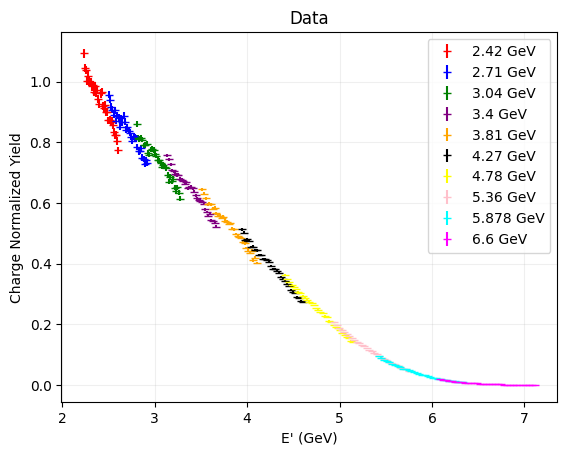

In [6]:
# Calculate the charge normalized yield and the uncertainty per bin
if ntg == 'He3' and leaky == 1:
    print("Analyzing leaky runs")
    delta_bin_contents_2p42_ntg, delta_bin_errors_2p42_ntg = datahist_from_array(delta_hist[2.42], 2.42, data_delta, ntg, eff_weight[2.42] / 1.0015)
    delta_bin_contents_2p71_ntg, delta_bin_errors_2p71_ntg = datahist_from_array(delta_hist[2.71], 2.71, data_delta, ntg, eff_weight[2.71] / 1.0537)
    delta_bin_contents_3p04_ntg, delta_bin_errors_3p04_ntg = datahist_from_array(delta_hist[3.04], 3.04, data_delta, ntg, eff_weight[3.04] / 1.0539)
    delta_bin_contents_3p4_ntg, delta_bin_errors_3p4_ntg = datahist_from_array(delta_hist[3.4], 3.4, data_delta, ntg, eff_weight[3.4] / 1.0818)
    delta_bin_contents_3p81_ntg, delta_bin_errors_3p81_ntg = datahist_from_array(delta_hist[3.81], 3.81, data_delta, ntg, eff_weight[3.81] / 1.0838)
    delta_bin_contents_4p27_ntg, delta_bin_errors_4p27_ntg = datahist_from_array(delta_hist[4.27], 4.27, data_delta, ntg, eff_weight[4.27] / 1.1104)
    delta_bin_contents_4p78_ntg, delta_bin_errors_4p78_ntg = datahist_from_array(delta_hist[4.78], 4.78, data_delta, ntg, eff_weight[4.78] / 1.1141)
    delta_bin_contents_5p36_ntg, delta_bin_errors_5p36_ntg = datahist_from_array(delta_hist[5.36], 5.36, data_delta, ntg, eff_weight[5.36] / 1.1810)
    delta_bin_contents_5p878_ntg, delta_bin_errors_5p878_ntg = datahist_from_array(delta_hist[5.878], 5.878, data_delta, ntg, eff_weight[5.878] / 1.18045)
    delta_bin_contents_6p6_ntg, delta_bin_errors_6p6_ntg = datahist_from_array(delta_hist[6.6], 6.6, data_delta, ntg, eff_weight[6.6] / 1.5401)
else:
    delta_bin_contents_2p42_ntg, delta_bin_errors_2p42_ntg = datahist_from_array(delta_hist[2.42], 2.42, data_delta, ntg, eff_weight[2.42])
    delta_bin_contents_2p71_ntg, delta_bin_errors_2p71_ntg = datahist_from_array(delta_hist[2.71], 2.71, data_delta, ntg, eff_weight[2.71])
    delta_bin_contents_3p04_ntg, delta_bin_errors_3p04_ntg = datahist_from_array(delta_hist[3.04], 3.04, data_delta, ntg, eff_weight[3.04])
    delta_bin_contents_3p4_ntg, delta_bin_errors_3p4_ntg = datahist_from_array(delta_hist[3.4], 3.4, data_delta, ntg, eff_weight[3.4])
    delta_bin_contents_3p81_ntg, delta_bin_errors_3p81_ntg = datahist_from_array(delta_hist[3.81], 3.81, data_delta, ntg, eff_weight[3.81])
    delta_bin_contents_4p27_ntg, delta_bin_errors_4p27_ntg = datahist_from_array(delta_hist[4.27], 4.27, data_delta, ntg, eff_weight[4.27])
    delta_bin_contents_4p78_ntg, delta_bin_errors_4p78_ntg = datahist_from_array(delta_hist[4.78], 4.78, data_delta, ntg, eff_weight[4.78])
    delta_bin_contents_5p36_ntg, delta_bin_errors_5p36_ntg = datahist_from_array(delta_hist[5.36], 5.36, data_delta, ntg, eff_weight[5.36])
    delta_bin_contents_5p878_ntg, delta_bin_errors_5p878_ntg = datahist_from_array(delta_hist[5.878], 5.878, data_delta, ntg, eff_weight[5.878])
    delta_bin_contents_6p6_ntg, delta_bin_errors_6p6_ntg = datahist_from_array(delta_hist[6.6], 6.6, data_delta, ntg, eff_weight[6.6])

_, delta_bin_edges_2p42 = np.histogram(delta_hist[2.42], bins = data_delta)
_, delta_bin_edges_2p71 = np.histogram(delta_hist[2.71], bins = data_delta)
_, delta_bin_edges_3p04 = np.histogram(delta_hist[3.04], bins = data_delta)
_, delta_bin_edges_3p4 = np.histogram(delta_hist[3.4], bins = data_delta)
_, delta_bin_edges_3p81 = np.histogram(delta_hist[3.81], bins = data_delta)
_, delta_bin_edges_4p27 = np.histogram(delta_hist[4.27], bins = data_delta)
_, delta_bin_edges_4p78 = np.histogram(delta_hist[4.78], bins = data_delta)
_, delta_bin_edges_5p36 = np.histogram(delta_hist[5.36], bins = data_delta)
_, delta_bin_edges_5p878 = np.histogram(delta_hist[5.878], bins = data_delta)
_, delta_bin_edges_6p6 = np.histogram(delta_hist[6.6], bins = data_delta)

delta_bin_centers_2p42 = (delta_bin_edges_2p42[:-1] + delta_bin_edges_2p42[1:]) / 2
delta_bin_centers_2p71 = (delta_bin_edges_2p71[:-1] + delta_bin_edges_2p71[1:]) / 2
delta_bin_centers_3p04 = (delta_bin_edges_3p04[:-1] + delta_bin_edges_3p04[1:]) / 2
delta_bin_centers_3p4 = (delta_bin_edges_3p4[:-1] + delta_bin_edges_3p4[1:]) / 2
delta_bin_centers_3p81 = (delta_bin_edges_3p81[:-1] + delta_bin_edges_3p81[1:]) / 2
delta_bin_centers_4p27 = (delta_bin_edges_4p27[:-1] + delta_bin_edges_4p27[1:]) / 2
delta_bin_centers_4p78 = (delta_bin_edges_4p78[:-1] + delta_bin_edges_4p78[1:]) / 2
delta_bin_centers_5p36 = (delta_bin_edges_5p36[:-1] + delta_bin_edges_5p36[1:]) / 2
delta_bin_centers_5p878 = (delta_bin_edges_5p878[:-1] + delta_bin_edges_5p878[1:]) / 2
delta_bin_centers_6p6 = (delta_bin_edges_6p6[:-1] + delta_bin_edges_6p6[1:]) / 2

binned_eprime_bin_centers_2p42 = 2.42 * (1 + 0.01 * delta_bin_centers_2p42)
binned_eprime_bin_centers_2p71 = 2.71 * (1 + 0.01 * delta_bin_centers_2p71)
binned_eprime_bin_centers_3p04 = 3.04 * (1 + 0.01 * delta_bin_centers_3p04)
binned_eprime_bin_centers_3p4 = 3.4 * (1 + 0.01 * delta_bin_centers_3p4)
binned_eprime_bin_centers_3p81 = 3.81 * (1 + 0.01 * delta_bin_centers_3p81)
binned_eprime_bin_centers_4p27 = 4.27 * (1 + 0.01 * delta_bin_centers_4p27)
binned_eprime_bin_centers_4p78 = 4.78 * (1 + 0.01 * delta_bin_centers_4p78)
binned_eprime_bin_centers_5p36 = 5.36 * (1 + 0.01 * delta_bin_centers_5p36)
binned_eprime_bin_centers_5p878 = 5.878 * (1 + 0.01 * delta_bin_centers_5p878)
binned_eprime_bin_centers_6p6 = 6.6 * (1 + 0.01 * delta_bin_centers_6p6)

# Calculate the charge symmetric background fraction per bin
csb_frac_2p42_ntg = csb(binned_eprime_bin_centers_2p42, ntg, dang)
csb_frac_2p71_ntg = csb(binned_eprime_bin_centers_2p71, ntg, dang)
csb_frac_3p04_ntg = csb(binned_eprime_bin_centers_3p04, ntg, dang)
csb_frac_3p4_ntg = csb(binned_eprime_bin_centers_3p4, ntg, dang)
csb_frac_3p81_ntg = csb(binned_eprime_bin_centers_3p81, ntg, dang)
csb_frac_4p27_ntg = csb(binned_eprime_bin_centers_4p27, ntg, dang)
csb_frac_4p78_ntg = csb(binned_eprime_bin_centers_4p78, ntg, dang)
csb_frac_5p36_ntg = csb(binned_eprime_bin_centers_5p36, ntg, dang)
csb_frac_5p878_ntg = csb(binned_eprime_bin_centers_5p878, ntg, dang)
csb_frac_6p6_ntg = csb(binned_eprime_bin_centers_6p6, ntg, dang)

# Subtract the charge symmetric background fraction from the total yield
subtracted_csb_contents_2p42_ntg = delta_bin_contents_2p42_ntg * (1 - csb_frac_2p42_ntg)
subtracted_csb_contents_2p71_ntg = delta_bin_contents_2p71_ntg * (1 - csb_frac_2p71_ntg)
subtracted_csb_contents_3p04_ntg = delta_bin_contents_3p04_ntg * (1 - csb_frac_3p04_ntg)
subtracted_csb_contents_3p4_ntg = delta_bin_contents_3p4_ntg * (1 - csb_frac_3p4_ntg)
subtracted_csb_contents_3p81_ntg = delta_bin_contents_3p81_ntg * (1 - csb_frac_3p81_ntg)
subtracted_csb_contents_4p27_ntg = delta_bin_contents_4p27_ntg * (1 - csb_frac_4p27_ntg)
subtracted_csb_contents_4p78_ntg = delta_bin_contents_4p78_ntg * (1 - csb_frac_4p78_ntg)
subtracted_csb_contents_5p36_ntg = delta_bin_contents_5p36_ntg * (1 - csb_frac_5p36_ntg)
subtracted_csb_contents_5p878_ntg = delta_bin_contents_5p878_ntg * (1 - csb_frac_5p878_ntg)
subtracted_csb_contents_6p6_ntg = delta_bin_contents_6p6_ntg * (1 - csb_frac_6p6_ntg)

# Add the errors in quadrature
subtracted_csb_errors_2p42_ntg = delta_bin_errors_2p42_ntg * (1 - csb_frac_2p42_ntg)
subtracted_csb_errors_2p71_ntg = delta_bin_errors_2p71_ntg * (1 - csb_frac_2p71_ntg)
subtracted_csb_errors_3p04_ntg = delta_bin_errors_3p04_ntg * (1 - csb_frac_3p04_ntg)
subtracted_csb_errors_3p4_ntg = delta_bin_errors_3p4_ntg * (1 - csb_frac_3p4_ntg)
subtracted_csb_errors_3p81_ntg = delta_bin_errors_3p81_ntg * (1 - csb_frac_3p81_ntg)
subtracted_csb_errors_4p27_ntg = delta_bin_errors_4p27_ntg * (1 - csb_frac_4p27_ntg)
subtracted_csb_errors_4p78_ntg = delta_bin_errors_4p78_ntg * (1 - csb_frac_4p78_ntg)
subtracted_csb_errors_5p36_ntg = delta_bin_errors_5p36_ntg * (1 - csb_frac_5p36_ntg)
subtracted_csb_errors_5p878_ntg = delta_bin_errors_5p878_ntg * (1 - csb_frac_5p878_ntg)
subtracted_csb_errors_6p6_ntg = delta_bin_errors_6p6_ntg * (1 - csb_frac_6p6_ntg)

# fig refers to the entire canvas on which plots are drawn. ax refers to a single plot/subplot
fig, ax = plt.subplots()
ax.errorbar(binned_eprime_bin_centers_2p42, delta_bin_contents_2p42_ntg, yerr = delta_bin_errors_2p42_ntg, fmt = '_', color = 'red', label = '2.42 GeV')
ax.errorbar(binned_eprime_bin_centers_2p71, delta_bin_contents_2p71_ntg, yerr = delta_bin_errors_2p71_ntg, fmt = '_', color = 'blue', label = '2.71 GeV')
ax.errorbar(binned_eprime_bin_centers_3p04, delta_bin_contents_3p04_ntg, yerr = delta_bin_errors_3p04_ntg, fmt = '_', color = 'green', label = '3.04 GeV')
ax.errorbar(binned_eprime_bin_centers_3p4, delta_bin_contents_3p4_ntg, yerr = delta_bin_errors_3p4_ntg, fmt = '_', color = 'purple', label = '3.4 GeV')
ax.errorbar(binned_eprime_bin_centers_3p81, delta_bin_contents_3p81_ntg, yerr = delta_bin_errors_3p81_ntg, fmt = '_', color = 'orange', label = '3.81 GeV')
ax.errorbar(binned_eprime_bin_centers_4p27, delta_bin_contents_4p27_ntg, yerr = delta_bin_errors_4p27_ntg, fmt = '_', color = 'black', label = '4.27 GeV')
ax.errorbar(binned_eprime_bin_centers_4p78, delta_bin_contents_4p78_ntg, yerr = delta_bin_errors_4p78_ntg, fmt = '_', color = 'yellow', label = '4.78 GeV')
ax.errorbar(binned_eprime_bin_centers_5p36, delta_bin_contents_5p36_ntg, yerr = delta_bin_errors_5p36_ntg, fmt = '_', color = 'pink', label = '5.36 GeV')
ax.errorbar(binned_eprime_bin_centers_5p878, delta_bin_contents_5p878_ntg, yerr = delta_bin_errors_5p878_ntg, fmt = '_', color = 'cyan', label = '5.878 GeV')
ax.errorbar(binned_eprime_bin_centers_6p6, delta_bin_contents_6p6_ntg, yerr = delta_bin_errors_6p6_ntg, fmt = '_', color = 'magenta', label = '6.6 GeV')
ax.set_ylabel('Charge Normalized Yield')
ax.set_xlabel('E\' (GeV)')
ax.set_title('Data')
ax.legend()
# ax.set_yscale('log')
ax.grid(alpha = 0.2)
# fig.savefig(f'{folder}/{nsimstring}_{dsimstring}_newyield.pdf')

In [7]:
print(delta_bin_contents_2p42_ntg)
print(subtracted_csb_contents_2p42_ntg)

[1.0932539  1.04456039 1.03760417 1.00244708 1.01993163 1.00037902
 0.99793494 0.98402251 0.98853465 0.96446991 0.98421052 0.96221384
 0.97274216 0.94247322 0.92529439 0.96074512 0.9645917  0.91984972
 0.91287116 0.92381052 0.90098874 0.89985709 0.87175423 0.87326311
 0.86817065 0.87024536 0.85647684 0.83535255 0.82328153 0.82479041
 0.80385473 0.77311134]
[0.99905544 0.95665735 0.9523237  0.9219784  0.93996955 0.92377966
 0.92330547 0.91215034 0.91801743 0.89727451 0.91723957 0.89826722
 0.90960409 0.88272704 0.86800573 0.90264935 0.90762418 0.86679204
 0.86144448 0.87298177 0.85257224 0.85262956 0.82706908 0.82954495
 0.82572145 0.82868745 0.81653068 0.79730061 0.78665439 0.78895224
 0.76974114 0.74106788]


<h1 align = 'center'> TARGET SPECIFIC DATA YIELD CORRECTION</h1>

In [8]:
if ntg == 'Ca48':
    print("Correcting for Ca40 contamination in Ca48 target")
    C = 0.113 # Ratio of Ca40 contamination in Ca48 target to Ca40 target
    cont_tg = 'Ca40'

elif ntg == 'B10':
    print("Correcting for C12 contamination in B10 target")
    C = 0.231 # Ratio of C12 contamination in B10 target to C12 target
    cont_tg = 'C12'

elif ntg == 'B11':
    print("Correcting for C12 contamination in B11 target")
    C = 0.236 # Ratio of C12 contamination in B11 target to C12 target
    cont_tg = 'C12'

elif ntg == 'He3' or ntg == 'LD2' or ntg == 'He4':
    print("Performing Aluminum cell wall subtraction")
    C = 0.2165 # Mean of Ratio of upstream & downstream dummy to target cell thickness
    cont_tg = ald
    
else:
    print("No contamination correction needed")
    C = 0

if C != 0:
    cont_dict_name = f'{cont_tg}_dict' # Dictionary containing the runs for the contaminant
    cont_dict = globals()[cont_dict_name]    
    for momentum in dmom:
        files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in cont_dict[momentum]]
        branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag']
        electrons = uproot.concatenate(files, branches)

        data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
        dp_cut = electrons['H_gtr_dp'][data_cut]
        theta_cut = electrons['H_gtr_th'][data_cut]
        phi_cut = electrons['H_gtr_ph'][data_cut]

        eff_weight[momentum] = 1 / cereff(dp_cut) # Cherenkov efficiency correction

        theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts) / np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
        delta_hist[momentum] = np.array(dp_cut)

    # Get yield and yield error from array
    contaminant_eprime_bin_contents_2p42, contaminant_eprime_bin_errors_2p42 = datahist_from_array(delta_hist[2.42], 2.42, data_delta, cont_tg, eff_weight[2.42])
    contaminant_eprime_bin_contents_2p71, contaminant_eprime_bin_errors_2p71 = datahist_from_array(delta_hist[2.71], 2.71, data_delta, cont_tg, eff_weight[2.71])
    contaminant_eprime_bin_contents_3p04, contaminant_eprime_bin_errors_3p04 = datahist_from_array(delta_hist[3.04], 3.04, data_delta, cont_tg, eff_weight[3.04])
    contaminant_eprime_bin_contents_3p4, contaminant_eprime_bin_errors_3p4 = datahist_from_array(delta_hist[3.4], 3.4, data_delta, cont_tg, eff_weight[3.4])
    contaminant_eprime_bin_contents_3p81, contaminant_eprime_bin_errors_3p81 = datahist_from_array(delta_hist[3.81], 3.81, data_delta, cont_tg, eff_weight[3.81])
    contaminant_eprime_bin_contents_4p27, contaminant_eprime_bin_errors_4p27 = datahist_from_array(delta_hist[4.27], 4.27, data_delta, cont_tg, eff_weight[4.27])
    contaminant_eprime_bin_contents_4p78, contaminant_eprime_bin_errors_4p78 = datahist_from_array(delta_hist[4.78], 4.78, data_delta, cont_tg, eff_weight[4.78])
    contaminant_eprime_bin_contents_5p36, contaminant_eprime_bin_errors_5p36 = datahist_from_array(delta_hist[5.36], 5.36, data_delta, cont_tg, eff_weight[5.36])
    contaminant_eprime_bin_contents_5p878, contaminant_eprime_bin_errors_5p878 = datahist_from_array(delta_hist[5.878], 5.878, data_delta, cont_tg, eff_weight[5.878])
    contaminant_eprime_bin_contents_6p6, contaminant_eprime_bin_errors_6p6 = datahist_from_array(delta_hist[6.6], 6.6, data_delta, cont_tg, eff_weight[6.6])

    # Calculate the charge symmetric background fraction per bin for contaminant
    csb_frac_2p42_cont = csb(binned_eprime_bin_centers_2p42, cont_tg, dang)
    csb_frac_2p71_cont = csb(binned_eprime_bin_centers_2p71, cont_tg, dang)
    csb_frac_3p04_cont = csb(binned_eprime_bin_centers_3p04, cont_tg, dang)
    csb_frac_3p4_cont = csb(binned_eprime_bin_centers_3p4, cont_tg, dang)
    csb_frac_3p81_cont = csb(binned_eprime_bin_centers_3p81, cont_tg, dang)
    csb_frac_4p27_cont = csb(binned_eprime_bin_centers_4p27, cont_tg, dang)
    csb_frac_4p78_cont = csb(binned_eprime_bin_centers_4p78, cont_tg, dang)
    csb_frac_5p36_cont = csb(binned_eprime_bin_centers_5p36, cont_tg, dang)
    csb_frac_5p878_cont = csb(binned_eprime_bin_centers_5p878, cont_tg, dang)
    csb_frac_6p6_cont = csb(binned_eprime_bin_centers_6p6, cont_tg, dang)

    # Error propagation
    contaminant_eprime_bin_errors_2p42 = contaminant_eprime_bin_errors_2p42 * (1 - csb_frac_2p42_cont)
    contaminant_eprime_bin_errors_2p71 = contaminant_eprime_bin_errors_2p71 * (1 - csb_frac_2p71_cont)
    contaminant_eprime_bin_errors_3p04 = contaminant_eprime_bin_errors_3p04 * (1 - csb_frac_3p04_cont)
    contaminant_eprime_bin_errors_3p4 = contaminant_eprime_bin_errors_3p4 * (1 - csb_frac_3p4_cont)
    contaminant_eprime_bin_errors_3p81 = contaminant_eprime_bin_errors_3p81 * (1 - csb_frac_3p81_cont)
    contaminant_eprime_bin_errors_4p27 = contaminant_eprime_bin_errors_4p27 * (1 - csb_frac_4p27_cont)
    contaminant_eprime_bin_errors_4p78 = contaminant_eprime_bin_errors_4p78 * (1 - csb_frac_4p78_cont)
    contaminant_eprime_bin_errors_5p36 = contaminant_eprime_bin_errors_5p36 * (1 - csb_frac_5p36_cont)
    contaminant_eprime_bin_errors_5p878 = contaminant_eprime_bin_errors_5p878 * (1 - csb_frac_5p878_cont)
    contaminant_eprime_bin_errors_6p6 = contaminant_eprime_bin_errors_6p6 * (1 - csb_frac_6p6_cont)

    # Subtract CSB from the total yield of the contaminant
    subtracted_bin_contents_2p42_cont = contaminant_eprime_bin_contents_2p42 * (1 - csb_frac_2p42_cont)
    subtracted_bin_contents_2p71_cont = contaminant_eprime_bin_contents_2p71 * (1 - csb_frac_2p71_cont)
    subtracted_bin_contents_3p04_cont = contaminant_eprime_bin_contents_3p04 * (1 - csb_frac_3p04_cont)
    subtracted_bin_contents_3p4_cont = contaminant_eprime_bin_contents_3p4 * (1 - csb_frac_3p4_cont)
    subtracted_bin_contents_3p81_cont = contaminant_eprime_bin_contents_3p81 * (1 - csb_frac_3p81_cont)
    subtracted_bin_contents_4p27_cont = contaminant_eprime_bin_contents_4p27 * (1 - csb_frac_4p27_cont)
    subtracted_bin_contents_4p78_cont = contaminant_eprime_bin_contents_4p78 * (1 - csb_frac_4p78_cont)
    subtracted_bin_contents_5p36_cont = contaminant_eprime_bin_contents_5p36 * (1 - csb_frac_5p36_cont)
    subtracted_bin_contents_5p878_cont = contaminant_eprime_bin_contents_5p878 * (1 - csb_frac_5p878_cont)
    subtracted_bin_contents_6p6_cont = contaminant_eprime_bin_contents_6p6 * (1 - csb_frac_6p6_cont)

    # Perform Contamination Subtraction
    subtracted_bin_contents_2p42_ntg = subtracted_csb_contents_2p42_ntg - (C * subtracted_bin_contents_2p42_cont)
    subtracted_bin_contents_2p71_ntg = subtracted_csb_contents_2p71_ntg - (C * subtracted_bin_contents_2p71_cont)
    subtracted_bin_contents_3p04_ntg = subtracted_csb_contents_3p04_ntg - (C * subtracted_bin_contents_3p04_cont)
    subtracted_bin_contents_3p4_ntg = subtracted_csb_contents_3p4_ntg - (C * subtracted_bin_contents_3p4_cont)
    subtracted_bin_contents_3p81_ntg = subtracted_csb_contents_3p81_ntg - (C * subtracted_bin_contents_3p81_cont)
    subtracted_bin_contents_4p27_ntg = subtracted_csb_contents_4p27_ntg - (C * subtracted_bin_contents_4p27_cont)
    subtracted_bin_contents_4p78_ntg = subtracted_csb_contents_4p78_ntg - (C * subtracted_bin_contents_4p78_cont)
    subtracted_bin_contents_5p36_ntg = subtracted_csb_contents_5p36_ntg - (C * subtracted_bin_contents_5p36_cont)
    subtracted_bin_contents_5p878_ntg = subtracted_csb_contents_5p878_ntg - (C * subtracted_bin_contents_5p878_cont)
    subtracted_bin_contents_6p6_ntg = subtracted_csb_contents_6p6_ntg - (C * subtracted_bin_contents_6p6_cont)

    # Add the errors in quadrature
    subtracted_bin_errors_2p42_ntg = np.sqrt((subtracted_csb_errors_2p42_ntg)**2 + (C * contaminant_eprime_bin_errors_2p42)**2)
    subtracted_bin_errors_2p71_ntg = np.sqrt((subtracted_csb_errors_2p71_ntg)**2 + (C * contaminant_eprime_bin_errors_2p71)**2)
    subtracted_bin_errors_3p04_ntg = np.sqrt((subtracted_csb_errors_3p04_ntg)**2 + (C * contaminant_eprime_bin_errors_3p04)**2)
    subtracted_bin_errors_3p4_ntg = np.sqrt((subtracted_csb_errors_3p4_ntg)**2 + (C * contaminant_eprime_bin_errors_3p4)**2)
    subtracted_bin_errors_3p81_ntg = np.sqrt((subtracted_csb_errors_3p81_ntg)**2 + (C * contaminant_eprime_bin_errors_3p81)**2)
    subtracted_bin_errors_4p27_ntg = np.sqrt((subtracted_csb_errors_4p27_ntg)**2 + (C * contaminant_eprime_bin_errors_4p27)**2)
    subtracted_bin_errors_4p78_ntg = np.sqrt((subtracted_csb_errors_4p78_ntg)**2 + (C * contaminant_eprime_bin_errors_4p78)**2)
    subtracted_bin_errors_5p36_ntg = np.sqrt((subtracted_csb_errors_5p36_ntg)**2 + (C * contaminant_eprime_bin_errors_5p36)**2)
    subtracted_bin_errors_5p878_ntg = np.sqrt((subtracted_csb_errors_5p878_ntg)**2 + (C * contaminant_eprime_bin_errors_5p878)**2)
    subtracted_bin_errors_6p6_ntg = np.sqrt((subtracted_csb_errors_6p6_ntg)**2 + (C * contaminant_eprime_bin_errors_6p6)**2)

    # def cryo_boiling(ntg):
    #     if ntg == 'He3':
    #         return 1 - 
    #     elif ntg == 'He4':
    #         return 0.90
    #     else:
    #         return
    # if ntg == 'He3' or ntg == 'He4':
    #     subtracted_bin_contents_2p42_ntg = subtracted_bin_contents_2p42_ntg * cryo_boiling(ntg)
    #     subtracted_bin_contents_2p71_ntg = subtracted_bin_contents_2p71_ntg * cryo_boiling(ntg)
    #     subtracted_bin_contents_3p04_ntg = subtracted_bin_contents_3p04_ntg * cryo_boiling(ntg)
    #     subtracted_bin_contents_3p4_ntg = subtracted_bin_contents_3p4_ntg * cryo_boiling(ntg)
    #     subtracted_bin_contents_3p81_ntg = subtracted_bin_contents_3p81_ntg * cryo_boiling(ntg)
    #     subtracted_bin_contents_4p27_ntg = subtracted_bin_contents_4p27_ntg * cryo_boiling(ntg)
    #     subtracted_bin_contents_4p78_ntg = subtracted_bin_contents_4p78_ntg * cryo_boiling(ntg)
    #     subtracted_bin_contents_5p36_ntg = subtracted_bin_contents_5p36_ntg * cryo_boiling(ntg)
    #     subtracted_bin_contents_5p878_ntg = subtracted_bin_contents_5p878_ntg * cryo_boiling(ntg)
    #     subtracted_bin_contents_6p6_ntg = subtracted_bin_contents_6p6_ntg * cryo_boiling(ntg)

    #     subtracted_bin_errors_2p42_ntg = subtracted_bin_errors_2p42_ntg * cryo_boiling(ntg)
    #     subtracted_bin_errors_2p71_ntg = subtracted_bin_errors_2p71_ntg * cryo_boiling(ntg)
    #     subtracted_bin_errors_3p04_ntg = subtracted_bin_errors_3p04_ntg * cryo_boiling(ntg)
    #     subtracted_bin_errors_3p4_ntg = subtracted_bin_errors_3p4_ntg * cryo_boiling(ntg)
    #     subtracted_bin_errors_3p81_ntg = subtracted_bin_errors_3p81_ntg * cryo_boiling(ntg)
    #     subtracted_bin_errors_4p27_ntg = subtracted_bin_errors_4p27_ntg * cryo_boiling(ntg)
    #     subtracted_bin_errors_4p78_ntg = subtracted_bin_errors_4p78_ntg * cryo_boiling(ntg)
    #     subtracted_bin_errors_5p36_ntg = subtracted_bin_errors_5p36_ntg * cryo_boiling(ntg)
    #     subtracted_bin_errors_5p878_ntg = subtracted_bin_errors_5p878_ntg * cryo_boiling(ntg)
    #     subtracted_bin_errors_6p6_ntg = subtracted_bin_errors_6p6_ntg * cryo_boiling(ntg)

    fig, ax = plt.subplots()
    ax.errorbar(binned_eprime_bin_centers_2p42, subtracted_bin_contents_2p42_ntg, yerr = subtracted_bin_errors_2p42_ntg, fmt = '_', color = 'red', label = '2.42 GeV') 
    ax.errorbar(binned_eprime_bin_centers_2p71, subtracted_bin_contents_2p71_ntg, yerr = subtracted_bin_errors_2p71_ntg, fmt = '_', color = 'blue', label = '2.71 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p04, subtracted_bin_contents_3p04_ntg, yerr = subtracted_bin_errors_3p04_ntg, fmt = '_', color = 'green', label = '3.04 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p4, subtracted_bin_contents_3p4_ntg, yerr = subtracted_bin_errors_3p4_ntg, fmt = '_', color = 'orange', label = '3.4 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p81, subtracted_bin_contents_3p81_ntg, yerr = subtracted_bin_errors_3p81_ntg, fmt = '_', color = 'purple', label = '3.81 GeV')
    ax.errorbar(binned_eprime_bin_centers_4p27, subtracted_bin_contents_4p27_ntg, yerr = subtracted_bin_errors_4p27_ntg, fmt = '_', color = 'yellow', label = '4.27 GeV')
    ax.errorbar(binned_eprime_bin_centers_4p78, subtracted_bin_contents_4p78_ntg, yerr = subtracted_bin_errors_4p78_ntg, fmt = '_', color = 'pink', label = '4.78 GeV')
    ax.errorbar(binned_eprime_bin_centers_5p36, subtracted_bin_contents_5p36_ntg, yerr = subtracted_bin_errors_5p36_ntg, fmt = '_', color = 'brown', label = '5.36 GeV')
    ax.errorbar(binned_eprime_bin_centers_5p878, subtracted_bin_contents_5p878_ntg, yerr = subtracted_bin_errors_5p878_ntg, fmt = '_', color = 'cyan', label = '5.878 GeV')
    ax.errorbar(binned_eprime_bin_centers_6p6, subtracted_bin_contents_6p6_ntg, yerr = subtracted_bin_errors_6p6_ntg, fmt = '_', color = 'limegreen', label = '6.6 GeV')
    ax.set_xlabel('E\' (GeV)')
    ax.set_ylabel('Charge Normalized Yield')
    ax.set_title('Data-Contamination Subtracted')
    ax.grid(alpha = 0.2)
    # ax.set_yscale('log')
    # fig.savefig(f'{folder}/plots/contamination_subtraction_yield_{ntg}_{time.time():.0f}.pdf')

No contamination correction needed


<h1 align="center">SIMULATION WORK FOR NTG</h1>


In [9]:
# Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor(f"/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/{xsec_tables}/xem2_emc_rc_{nsimstring}22_hms.out")
# if ntg == 'LD2':
#     V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor("/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xsec_tables/xem2_emc_rc_d2cryo22_hms.out")

Eprime_dict = {}
delta_dict = {}
xsec_array = {}
mc_scale = {}
thetadict = {}
ytar_weight = {}
ytarcut = {}
jacobian_weight = {}
delta_weight = {}
idang = int(dang)

for momentum in dmom:
    mom_str = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
    # mom_str = str(momentum).replace('-', '').replace('.', 'p')
    # filepath = f"/Volumes/smriti/xem2/worksim/hms_mc_{nsimstring}_{idang}degm{mom_str}.root"
    # New MC files
    filepath = f"/Volumes/smriti/xem2/worksim/hms_{idang}deg_{mom_str}gev_{nsimstring}.root"

    # Open the file and tree
    file = uproot.open(filepath)
    tree = file["h10"]

    # Load the branches
    electrons = tree.arrays(["hsdeltai", "hsytar", "hsyptari", "hsxptari", "stop_id"], library = 'np')    
    nentries = len(electrons["hsdeltai"])

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdeltai"]) <= 8) & \
            (np.abs(electrons["hsyptari"]) < 0.032) & \
            (np.abs(electrons["hsxptari"]) < 0.085) & \
            (electrons["stop_id"] == 0)
    
    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdeltai"][mc_cut]
    hsyptar_cut = electrons["hsyptari"][mc_cut]
    hsxptar_cut = electrons["hsxptari"][mc_cut]
    hsytar_cut = electrons["hsytar"][mc_cut]

    delta_dict[momentum] = hsdelta_cut

    # Dave's delta correction
    delta_weight[momentum] = delta_correction(hsdelta_cut)

    # Calculate E' and theta (in degrees)
    Eprime_dict[momentum] = momentum * (1 + 0.01 * hsdelta_cut)
    thetarad = np.arccos((cos_ts + hsyptar_cut * sin_ts) / np.sqrt(1 + hsxptar_cut * hsxptar_cut + hsyptar_cut * hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)

    # Calculate the ytar acceptance correction factor
    ytar_weight[momentum] = -0.00812174 * hsytar_cut**2 - 0.0000415678 * hsytar_cut + 1.00021
    ytarcut[momentum] = hsytar_cut

    # MC Jacobian
    jacobian_weight[momentum] = np.power((1 + np.power(hsxptar_cut, 2) + np.power(hsyptar_cut, 2)), -1.5)
        
    # Perform the interpolation
    points_ntg = np.array([V2, V3]).T # Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))
    xsec_array[momentum] = griddata(points_ntg, V9, points_to_interpolate, method = 'linear') # Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section (V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
    mc_scale[momentum] = (lumin * domega * (ep_max[momentum] - ep_min[momentum])) / nentries         # Calculate the scale for simulation
    # print(f"Scale for {momentum} GeV: {mc_scale[momentum]}")
    thetadict[momentum] = thetadeg

Should be -8 and +8 -7.999974721577013 7.999982623849061


Text(0.5, 1.0, 'Ag108@20.0˚ Simulation')

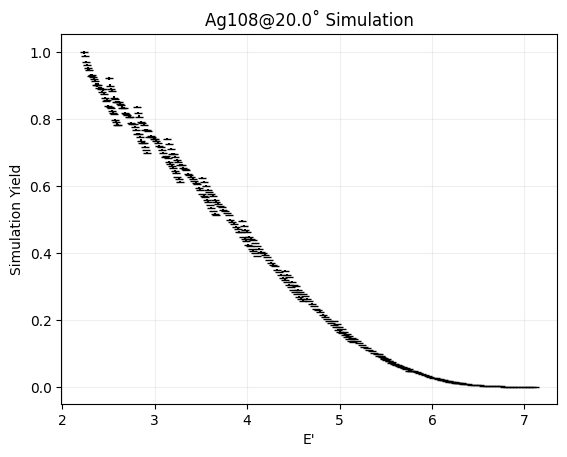

In [10]:
hsdelta_min, hsdelta_max = np.min(delta_dict[2.42]), np.max(delta_dict[2.42])
print("Should be -8 and +8", hsdelta_min, hsdelta_max)
hsdelta_binedges = np.linspace(hsdelta_min, hsdelta_max, bin_per_mom + 1)

# This function returns 2 arrays: bin counts (the counts in each bin taking weights into account) and bin edges (the edges of the bins)
bin_edges_delta_2p42 = np.histogram(delta_dict[2.42], weights = xsec_array[2.42] * mc_scale[2.42], bins = hsdelta_binedges)[1]
bin_edges_delta_2p71 = np.histogram(delta_dict[2.71], weights = xsec_array[2.71] * mc_scale[2.71], bins = hsdelta_binedges)[1]
bin_edges_delta_3p04 = np.histogram(delta_dict[3.04], weights = xsec_array[3.04] * mc_scale[3.04], bins = hsdelta_binedges)[1]
bin_edges_delta_3p4 = np.histogram(delta_dict[3.4], weights = xsec_array[3.4] * mc_scale[3.4], bins = hsdelta_binedges)[1]
bin_edges_delta_3p81 = np.histogram(delta_dict[3.81], weights = xsec_array[3.81] * mc_scale[3.81], bins = hsdelta_binedges)[1]
bin_edges_delta_4p27 = np.histogram(delta_dict[4.27], weights = xsec_array[4.27] * mc_scale[4.27], bins = hsdelta_binedges)[1]
bin_edges_delta_4p78 = np.histogram(delta_dict[4.78], weights = xsec_array[4.78] * mc_scale[4.78], bins = hsdelta_binedges)[1]
bin_edges_delta_5p36 = np.histogram(delta_dict[5.36], weights = xsec_array[5.36] * mc_scale[5.36], bins = hsdelta_binedges)[1]
bin_edges_delta_5p878 = np.histogram(delta_dict[5.878], weights = xsec_array[5.878] * mc_scale[5.878], bins = hsdelta_binedges)[1]
bin_edges_delta_6p6 = np.histogram(delta_dict[6.6], weights = xsec_array[6.6] * mc_scale[6.6], bins = hsdelta_binedges)[1]

# Gets the yield and yield error
bin_counts_eprime_2p42_mc_ntg, bin_errors_eprime_2p42_mc_ntg = mchist_from_array(delta_dict[2.42], xsec_array[2.42] * mc_scale[2.42] * ytar_weight[2.42] * jacobian_weight[2.42] * delta_weight[2.42], hsdelta_binedges)
bin_counts_eprime_2p71_mc_ntg, bin_errors_eprime_2p71_mc_ntg = mchist_from_array(delta_dict[2.71], xsec_array[2.71] * mc_scale[2.71] * ytar_weight[2.71] * jacobian_weight[2.71] * delta_weight[2.71], hsdelta_binedges)
bin_counts_eprime_3p04_mc_ntg, bin_errors_eprime_3p04_mc_ntg = mchist_from_array(delta_dict[3.04], xsec_array[3.04] * mc_scale[3.04] * ytar_weight[3.04] * jacobian_weight[3.04] * delta_weight[3.04], hsdelta_binedges)
bin_counts_eprime_3p4_mc_ntg, bin_errors_eprime_3p4_mc_ntg = mchist_from_array(delta_dict[3.4], xsec_array[3.4] * mc_scale[3.4] * ytar_weight[3.4] * jacobian_weight[3.4] * delta_weight[3.4], hsdelta_binedges)
bin_counts_eprime_3p81_mc_ntg, bin_errors_eprime_3p81_mc_ntg = mchist_from_array(delta_dict[3.81], xsec_array[3.81] * mc_scale[3.81] * ytar_weight[3.81] * jacobian_weight[3.81] * delta_weight[3.81], hsdelta_binedges)
bin_counts_eprime_4p27_mc_ntg, bin_errors_eprime_4p27_mc_ntg = mchist_from_array(delta_dict[4.27], xsec_array[4.27] * mc_scale[4.27] * ytar_weight[4.27] * jacobian_weight[4.27] * delta_weight[4.27], hsdelta_binedges)
bin_counts_eprime_4p78_mc_ntg, bin_errors_eprime_4p78_mc_ntg = mchist_from_array(delta_dict[4.78], xsec_array[4.78] * mc_scale[4.78] * ytar_weight[4.78] * jacobian_weight[4.78] * delta_weight[4.78], hsdelta_binedges)
bin_counts_eprime_5p36_mc_ntg, bin_errors_eprime_5p36_mc_ntg = mchist_from_array(delta_dict[5.36], xsec_array[5.36] * mc_scale[5.36] * ytar_weight[5.36] * jacobian_weight[5.36] * delta_weight[5.36], hsdelta_binedges)
bin_counts_eprime_5p878_mc_ntg, bin_errors_eprime_5p878_mc_ntg = mchist_from_array(delta_dict[5.878], xsec_array[5.878] * mc_scale[5.878] * ytar_weight[5.878] * jacobian_weight[5.878] * delta_weight[5.878], hsdelta_binedges)
bin_counts_eprime_6p6_mc_ntg, bin_errors_eprime_6p6_mc_ntg = mchist_from_array(delta_dict[6.6], xsec_array[6.6] * mc_scale[6.6] * ytar_weight[6.6] * jacobian_weight[6.6] * delta_weight[6.6], hsdelta_binedges)

bin_centers_delta_2p42 = (bin_edges_delta_2p42[:-1] + bin_edges_delta_2p42[1:]) / 2
bin_centers_delta_2p71 = (bin_edges_delta_2p71[:-1] + bin_edges_delta_2p71[1:]) / 2
bin_centers_delta_3p04 = (bin_edges_delta_3p04[:-1] + bin_edges_delta_3p04[1:]) / 2
bin_centers_delta_3p4 = (bin_edges_delta_3p4[:-1] + bin_edges_delta_3p4[1:]) / 2
bin_centers_delta_3p81 = (bin_edges_delta_3p81[:-1] + bin_edges_delta_3p81[1:]) / 2
bin_centers_delta_4p27 = (bin_edges_delta_4p27[:-1] + bin_edges_delta_4p27[1:]) / 2
bin_centers_delta_4p78 = (bin_edges_delta_4p78[:-1] + bin_edges_delta_4p78[1:]) / 2
bin_centers_delta_5p36 = (bin_edges_delta_5p36[:-1] + bin_edges_delta_5p36[1:]) / 2
bin_centers_delta_5p878 = (bin_edges_delta_5p878[:-1] + bin_edges_delta_5p878[1:]) / 2
bin_centers_delta_6p6 = (bin_edges_delta_6p6[:-1] + bin_edges_delta_6p6[1:]) / 2

binned_eprime_bin_centers_2p42_mc_ntg = 2.42 * (1 + 0.01 * bin_centers_delta_2p42)
binned_eprime_bin_centers_2p71_mc_ntg = 2.71 * (1 + 0.01 * bin_centers_delta_2p71)
binned_eprime_bin_centers_3p04_mc_ntg = 3.04 * (1 + 0.01 * bin_centers_delta_3p04)
binned_eprime_bin_centers_3p4_mc_ntg = 3.4 * (1 + 0.01 * bin_centers_delta_3p4)
binned_eprime_bin_centers_3p81_mc_ntg = 3.81 * (1 + 0.01 * bin_centers_delta_3p81)
binned_eprime_bin_centers_4p27_mc_ntg = 4.27 * (1 + 0.01 * bin_centers_delta_4p27)
binned_eprime_bin_centers_4p78_mc_ntg = 4.78 * (1 + 0.01 * bin_centers_delta_4p78)
binned_eprime_bin_centers_5p36_mc_ntg = 5.36 * (1 + 0.01 * bin_centers_delta_5p36)
binned_eprime_bin_centers_5p878_mc_ntg = 5.878 * (1 + 0.01 * bin_centers_delta_5p878)
binned_eprime_bin_centers_6p6_mc_ntg = 6.6 * (1 + 0.01 * bin_centers_delta_6p6)

#Plotting the histogram with error bars
fig2, ax2 = plt.subplots()
ax2.errorbar(binned_eprime_bin_centers_2p42_mc_ntg, bin_counts_eprime_2p42_mc_ntg, yerr = bin_errors_eprime_2p42_mc_ntg, fmt = '_', color = 'black', label = 'Sim 2.42 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p71_mc_ntg, bin_counts_eprime_2p71_mc_ntg, yerr = bin_errors_eprime_2p71_mc_ntg, fmt = '_', color = 'black', label = 'Sim 2.71 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p04_mc_ntg, bin_counts_eprime_3p04_mc_ntg, yerr = bin_errors_eprime_3p04_mc_ntg, fmt = '_', color = 'black', label = 'Sim 3.04 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p4_mc_ntg, bin_counts_eprime_3p4_mc_ntg, yerr = bin_errors_eprime_3p4_mc_ntg, fmt = '_', color = 'black', label = 'Sim 3.4 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p81_mc_ntg, bin_counts_eprime_3p81_mc_ntg, yerr = bin_errors_eprime_3p81_mc_ntg, fmt = '_', color = 'black', label = 'Sim 3.81 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p27_mc_ntg, bin_counts_eprime_4p27_mc_ntg, yerr = bin_errors_eprime_4p27_mc_ntg, fmt = '_', color = 'black', label = 'Sim 4.27 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p78_mc_ntg, bin_counts_eprime_4p78_mc_ntg, yerr = bin_errors_eprime_4p78_mc_ntg, fmt = '_', color = 'black', label = 'Sim 4.78 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p36_mc_ntg, bin_counts_eprime_5p36_mc_ntg, yerr = bin_errors_eprime_5p36_mc_ntg, fmt = '_', color = 'black', label = 'Sim 5.36 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p878_mc_ntg, bin_counts_eprime_5p878_mc_ntg, yerr = bin_errors_eprime_5p878_mc_ntg, fmt = '_', color = 'black', label = 'Sim 5.878 GeV')
ax2.errorbar(binned_eprime_bin_centers_6p6_mc_ntg, bin_counts_eprime_6p6_mc_ntg, yerr = bin_errors_eprime_6p6_mc_ntg, fmt = '_', color = 'black', label = 'Sim 6.6 GeV')
ax2.grid(alpha = 0.2)
ax2.set_xlabel('E\'')
ax2.set_ylabel('Simulation Yield')
# ax2.set_yscale('log')
# ax.legend() 
ax2.set_title(f'{ntg}@{dang}˚ Simulation')
# fig2.savefig(f'{folder}/eprime_{ntg}_{dang}_{start_time:.0f}.pdf')

In [11]:
print(bin_counts_eprime_3p81_mc_ntg)

[0.62582429 0.61217056 0.60174737 0.59031596 0.58191472 0.57583716
 0.5705693  0.55893331 0.55401735 0.54808482 0.53980338 0.53909195
 0.53036319 0.52716889 0.51913236 0.51303371 0.5005202  0.49341344
 0.48868709 0.47900208 0.4721549  0.46462916 0.4618585  0.4471164
 0.44244054 0.43685152 0.4255606  0.42265116 0.41139355 0.4067425
 0.39996432 0.3911801 ]


In [12]:
if C == 0:
    subtracted_bin_contents_2p42_ntg = subtracted_csb_contents_2p42_ntg
    subtracted_bin_contents_2p71_ntg = subtracted_csb_contents_2p71_ntg
    subtracted_bin_contents_3p04_ntg = subtracted_csb_contents_3p04_ntg
    subtracted_bin_contents_3p4_ntg = subtracted_csb_contents_3p4_ntg
    subtracted_bin_contents_3p81_ntg = subtracted_csb_contents_3p81_ntg
    subtracted_bin_contents_4p27_ntg = subtracted_csb_contents_4p27_ntg
    subtracted_bin_contents_4p78_ntg = subtracted_csb_contents_4p78_ntg
    subtracted_bin_contents_5p36_ntg = subtracted_csb_contents_5p36_ntg
    subtracted_bin_contents_5p878_ntg = subtracted_csb_contents_5p878_ntg
    subtracted_bin_contents_6p6_ntg = subtracted_csb_contents_6p6_ntg

    subtracted_bin_errors_2p42_ntg = subtracted_csb_errors_2p42_ntg
    subtracted_bin_errors_2p71_ntg = subtracted_csb_errors_2p71_ntg
    subtracted_bin_errors_3p04_ntg = subtracted_csb_errors_3p04_ntg
    subtracted_bin_errors_3p4_ntg = subtracted_csb_errors_3p4_ntg
    subtracted_bin_errors_3p81_ntg = subtracted_csb_errors_3p81_ntg
    subtracted_bin_errors_4p27_ntg = subtracted_csb_errors_4p27_ntg
    subtracted_bin_errors_4p78_ntg = subtracted_csb_errors_4p78_ntg
    subtracted_bin_errors_5p36_ntg = subtracted_csb_errors_5p36_ntg
    subtracted_bin_errors_5p878_ntg = subtracted_csb_errors_5p878_ntg
    subtracted_bin_errors_6p6_ntg = subtracted_csb_errors_6p6_ntg

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR NTG</h1>


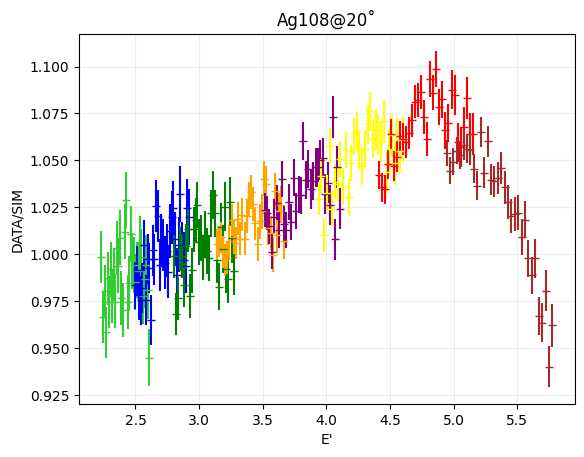

In [13]:
ratio_eprime_2p42_ntg = subtracted_bin_contents_2p42_ntg / bin_counts_eprime_2p42_mc_ntg
ratio_eprime_2p71_ntg = subtracted_bin_contents_2p71_ntg / bin_counts_eprime_2p71_mc_ntg
ratio_eprime_3p04_ntg = subtracted_bin_contents_3p04_ntg / bin_counts_eprime_3p04_mc_ntg
ratio_eprime_3p4_ntg = subtracted_bin_contents_3p4_ntg / bin_counts_eprime_3p4_mc_ntg
ratio_eprime_3p81_ntg = subtracted_bin_contents_3p81_ntg / bin_counts_eprime_3p81_mc_ntg
ratio_eprime_4p27_ntg = subtracted_bin_contents_4p27_ntg / bin_counts_eprime_4p27_mc_ntg
ratio_eprime_4p78_ntg = subtracted_bin_contents_4p78_ntg / bin_counts_eprime_4p78_mc_ntg
ratio_eprime_5p36_ntg = subtracted_bin_contents_5p36_ntg / bin_counts_eprime_5p36_mc_ntg
ratio_eprime_5p878_ntg = subtracted_bin_contents_5p878_ntg / bin_counts_eprime_5p878_mc_ntg
ratio_eprime_6p6_ntg = subtracted_bin_contents_6p6_ntg / bin_counts_eprime_6p6_mc_ntg

# Add errors in quadrature. First is data and second is MC
ratio_errors_2p42_ntg = ratio_eprime_2p42_ntg * np.sqrt((subtracted_bin_errors_2p42_ntg / subtracted_bin_contents_2p42_ntg)**2 + (bin_errors_eprime_2p42_mc_ntg / bin_counts_eprime_2p42_mc_ntg)**2)
ratio_errors_2p71_ntg = ratio_eprime_2p71_ntg * np.sqrt((subtracted_bin_errors_2p71_ntg / subtracted_bin_contents_2p71_ntg)**2 + (bin_errors_eprime_2p71_mc_ntg / bin_counts_eprime_2p71_mc_ntg)**2)
ratio_errors_3p04_ntg = ratio_eprime_3p04_ntg * np.sqrt((subtracted_bin_errors_3p04_ntg / subtracted_bin_contents_3p04_ntg)**2 + (bin_errors_eprime_3p04_mc_ntg / bin_counts_eprime_3p04_mc_ntg)**2)
ratio_errors_3p4_ntg = ratio_eprime_3p4_ntg * np.sqrt((subtracted_bin_errors_3p4_ntg / subtracted_bin_contents_3p4_ntg)**2 + (bin_errors_eprime_3p4_mc_ntg / bin_counts_eprime_3p4_mc_ntg)**2)
ratio_errors_3p81_ntg = ratio_eprime_3p81_ntg * np.sqrt((subtracted_bin_errors_3p81_ntg / subtracted_bin_contents_3p81_ntg)**2 + (bin_errors_eprime_3p81_mc_ntg / bin_counts_eprime_3p81_mc_ntg)**2)
ratio_errors_4p27_ntg = ratio_eprime_4p27_ntg * np.sqrt((subtracted_bin_errors_4p27_ntg / subtracted_bin_contents_4p27_ntg)**2 + (bin_errors_eprime_4p27_mc_ntg / bin_counts_eprime_4p27_mc_ntg)**2)
ratio_errors_4p78_ntg = ratio_eprime_4p78_ntg * np.sqrt((subtracted_bin_errors_4p78_ntg / subtracted_bin_contents_4p78_ntg)**2 + (bin_errors_eprime_4p78_mc_ntg / bin_counts_eprime_4p78_mc_ntg)**2)
ratio_errors_5p36_ntg = ratio_eprime_5p36_ntg * np.sqrt((subtracted_bin_errors_5p36_ntg / subtracted_bin_contents_5p36_ntg)**2 + (bin_errors_eprime_5p36_mc_ntg / bin_counts_eprime_5p36_mc_ntg)**2)
ratio_errors_5p878_ntg = ratio_eprime_5p878_ntg * np.sqrt((subtracted_bin_errors_5p878_ntg / subtracted_bin_contents_5p878_ntg)**2 + (bin_errors_eprime_5p878_mc_ntg / bin_counts_eprime_5p878_mc_ntg)**2)
ratio_errors_6p6_ntg = ratio_eprime_6p6_ntg * np.sqrt((subtracted_bin_errors_6p6_ntg / subtracted_bin_contents_6p6_ntg)**2 + (bin_errors_eprime_6p6_mc_ntg / bin_counts_eprime_6p6_mc_ntg)**2)

fig2, ax2 = plt.subplots()
ax2.errorbar(binned_eprime_bin_centers_2p42, ratio_eprime_2p42_ntg, yerr = ratio_errors_2p42_ntg, fmt = '_', color = 'limegreen', label = '2.42 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p71, ratio_eprime_2p71_ntg, yerr = ratio_errors_2p71_ntg, fmt = '_', color = 'blue', label = '2.71 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p04, ratio_eprime_3p04_ntg, yerr = ratio_errors_3p04_ntg, fmt = '_', color = 'green', label = '3.04 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p4, ratio_eprime_3p4_ntg, yerr = ratio_errors_3p4_ntg, fmt = '_', color = 'orange', label = '3.4 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p81, ratio_eprime_3p81_ntg, yerr = ratio_errors_3p81_ntg, fmt = '_', color = 'purple', label = '3.81 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p27, ratio_eprime_4p27_ntg, yerr = ratio_errors_4p27_ntg, fmt = '_', color = 'yellow', label = '4.27 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p78, ratio_eprime_4p78_ntg, yerr = ratio_errors_4p78_ntg, fmt = '_', color = 'red', label = '4.78 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p36, ratio_eprime_5p36_ntg, yerr = ratio_errors_5p36_ntg, fmt = '_', color = 'brown', label = '5.36 GeV')
# ax2.errorbar(binned_eprime_bin_centers_5p878, ratio_eprime_5p878_ntg, yerr = ratio_errors_5p878_ntg, fmt = '_', color = 'cyan', label = '5.878 GeV')
# ax2.errorbar(binned_eprime_bin_centers_6p6, ratio_eprime_6p6_ntg, yerr = ratio_errors_6p6_ntg, fmt = '_', color = 'lightgreen', label = '6.6 GeV')
ax2.set_xlabel('E\'')
ax2.set_ylabel('DATA/SIM')
ax2.set_title(f'{ntg}@{idang}˚')
ax2.grid(alpha = 0.2)
# ax2.set_ylim(0.5, 1.1)
# fig2.savefig(f'{folder}/yieldratio_{ntg}_{dang}_{folder}withsubt{thick}_{start_time:.0f}.pdf')

In [14]:
eprime_bins = np.concatenate((binned_eprime_bin_centers_2p42, binned_eprime_bin_centers_2p71, binned_eprime_bin_centers_3p04, binned_eprime_bin_centers_3p4, binned_eprime_bin_centers_3p81, binned_eprime_bin_centers_4p27, binned_eprime_bin_centers_4p78, binned_eprime_bin_centers_5p36, binned_eprime_bin_centers_5p878, binned_eprime_bin_centers_6p6))
ratio_bins = np.concatenate((ratio_eprime_2p42_ntg, ratio_eprime_2p71_ntg, ratio_eprime_3p04_ntg, ratio_eprime_3p4_ntg, ratio_eprime_3p81_ntg, ratio_eprime_4p27_ntg, ratio_eprime_4p78_ntg, ratio_eprime_5p36_ntg, ratio_eprime_5p878_ntg, ratio_eprime_6p6_ntg))
ratio_errors = np.concatenate((ratio_errors_2p42_ntg, ratio_errors_2p71_ntg, ratio_errors_3p04_ntg, ratio_errors_3p4_ntg, ratio_errors_3p81_ntg, ratio_errors_4p27_ntg, ratio_errors_4p78_ntg, ratio_errors_5p36_ntg, ratio_errors_5p878_ntg, ratio_errors_6p6_ntg))

# with open(f'{folder}/yieldratio_{ntg}_{idang}.txt', 'w') as f:
#     for i in range(len(eprime_bins)):
#         f.write(f'{eprime_bins[i]} {ratio_bins[i]}\t{ratio_errors[i]}\n')

<h1 align="center">BORN CROSS SECTION CALCULATION FOR NTG</h1>


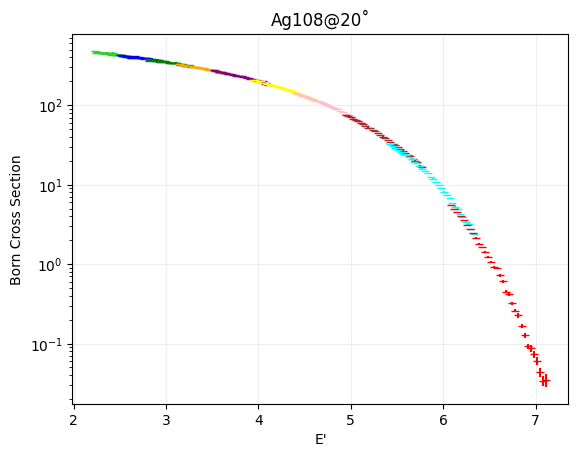

In [15]:
# Get points to interpolate based on angle and E'. Common for ntg and dtg
points_to_interpolate_2p42 = np.column_stack((binned_eprime_bin_centers_2p42, np.full(len(binned_eprime_bin_centers_2p42), dang)))
points_to_interpolate_2p71 = np.column_stack((binned_eprime_bin_centers_2p71, np.full(len(binned_eprime_bin_centers_2p71), dang)))
points_to_interpolate_3p04 = np.column_stack((binned_eprime_bin_centers_3p04, np.full(len(binned_eprime_bin_centers_3p04), dang)))
points_to_interpolate_3p4 = np.column_stack((binned_eprime_bin_centers_3p4, np.full(len(binned_eprime_bin_centers_3p4), dang)))
points_to_interpolate_3p81 = np.column_stack((binned_eprime_bin_centers_3p81, np.full(len(binned_eprime_bin_centers_3p81), dang)))
points_to_interpolate_4p27 = np.column_stack((binned_eprime_bin_centers_4p27, np.full(len(binned_eprime_bin_centers_4p27), dang)))
points_to_interpolate_4p78 = np.column_stack((binned_eprime_bin_centers_4p78, np.full(len(binned_eprime_bin_centers_4p78), dang)))
points_to_interpolate_5p36 = np.column_stack((binned_eprime_bin_centers_5p36, np.full(len(binned_eprime_bin_centers_5p36), dang)))
points_to_interpolate_5p878 = np.column_stack((binned_eprime_bin_centers_5p878, np.full(len(binned_eprime_bin_centers_5p878), dang)))
points_to_interpolate_6p6 = np.column_stack((binned_eprime_bin_centers_6p6, np.full(len(binned_eprime_bin_centers_6p6), dang)))

# Interpolate again to get model Born cross-section
born_xsec_array_2p42_ntg = griddata(points_ntg, V6, points_to_interpolate_2p42, method = 'linear') # points is just the whole stack of 2D array of [E', theta] from the table
born_xsec_array_2p71_ntg = griddata(points_ntg, V6, points_to_interpolate_2p71, method = 'linear')
born_xsec_array_3p04_ntg = griddata(points_ntg, V6, points_to_interpolate_3p04, method = 'linear')
born_xsec_array_3p4_ntg = griddata(points_ntg, V6, points_to_interpolate_3p4, method = 'linear')
born_xsec_array_3p81_ntg = griddata(points_ntg, V6, points_to_interpolate_3p81, method = 'linear')
born_xsec_array_4p27_ntg = griddata(points_ntg, V6, points_to_interpolate_4p27, method = 'linear')
born_xsec_array_4p78_ntg = griddata(points_ntg, V6, points_to_interpolate_4p78, method = 'linear')
born_xsec_array_5p36_ntg = griddata(points_ntg, V6, points_to_interpolate_5p36, method = 'linear')
born_xsec_array_5p878_ntg = griddata(points_ntg, V6, points_to_interpolate_5p878, method = 'linear')
born_xsec_array_6p6_ntg = griddata(points_ntg, V6, points_to_interpolate_6p6, method = 'linear')
# print("Length of born_xsec_array", len(born_xsec_array))

# Get the QE piece
qe_array_2p42_ntg = griddata(points_ntg, V8, points_to_interpolate_2p42, method = 'linear')
qe_array_2p71_ntg = griddata(points_ntg, V8, points_to_interpolate_2p71, method = 'linear')
qe_array_3p04_ntg = griddata(points_ntg, V8, points_to_interpolate_3p04, method = 'linear')
qe_array_3p4_ntg = griddata(points_ntg, V8, points_to_interpolate_3p4, method = 'linear')
qe_array_3p81_ntg = griddata(points_ntg, V8, points_to_interpolate_3p81, method = 'linear')
qe_array_4p27_ntg = griddata(points_ntg, V8, points_to_interpolate_4p27, method = 'linear')
qe_array_4p78_ntg = griddata(points_ntg, V8, points_to_interpolate_4p78, method = 'linear')
qe_array_5p36_ntg = griddata(points_ntg, V8, points_to_interpolate_5p36, method = 'linear')
qe_array_5p878_ntg = griddata(points_ntg, V8, points_to_interpolate_5p878, method = 'linear')
qe_array_6p6_ntg = griddata(points_ntg, V8, points_to_interpolate_6p6, method = 'linear')

# Interpolate 3rd time to get Coulomb correction factor
ccf_2p42_ntg = griddata(points_ntg, V13, points_to_interpolate_2p42, method = 'linear')
ccf_2p71_ntg = griddata(points_ntg, V13, points_to_interpolate_2p71, method = 'linear')
ccf_3p04_ntg = griddata(points_ntg, V13, points_to_interpolate_3p04, method = 'linear')
ccf_3p4_ntg = griddata(points_ntg, V13, points_to_interpolate_3p4, method = 'linear')
ccf_3p81_ntg = griddata(points_ntg, V13, points_to_interpolate_3p81, method = 'linear')
ccf_4p27_ntg = griddata(points_ntg, V13, points_to_interpolate_4p27, method = 'linear')
ccf_4p78_ntg = griddata(points_ntg, V13, points_to_interpolate_4p78, method = 'linear')
ccf_5p36_ntg = griddata(points_ntg, V13, points_to_interpolate_5p36, method = 'linear')
ccf_5p878_ntg = griddata(points_ntg, V13, points_to_interpolate_5p878, method = 'linear')
ccf_6p6_ntg = griddata(points_ntg, V13, points_to_interpolate_6p6, method = 'linear')

fig3, ax3 = plt.subplots()
# Calculate the data Born cross-section and apply Coloumb corrections
born_cross_2p42_ntg = ratio_eprime_2p42_ntg * born_xsec_array_2p42_ntg * ccf_2p42_ntg
born_cross_2p71_ntg = ratio_eprime_2p71_ntg * born_xsec_array_2p71_ntg * ccf_2p71_ntg
born_cross_3p04_ntg = ratio_eprime_3p04_ntg * born_xsec_array_3p04_ntg * ccf_3p04_ntg
born_cross_3p4_ntg= ratio_eprime_3p4_ntg * born_xsec_array_3p4_ntg * ccf_3p4_ntg
born_cross_3p81_ntg = ratio_eprime_3p81_ntg * born_xsec_array_3p81_ntg * ccf_3p81_ntg
born_cross_4p27_ntg = ratio_eprime_4p27_ntg * born_xsec_array_4p27_ntg * ccf_4p27_ntg
born_cross_4p78_ntg = ratio_eprime_4p78_ntg * born_xsec_array_4p78_ntg * ccf_4p78_ntg
born_cross_5p36_ntg = ratio_eprime_5p36_ntg * born_xsec_array_5p36_ntg * ccf_5p36_ntg
born_cross_5p878_ntg = ratio_eprime_5p878_ntg * born_xsec_array_5p878_ntg * ccf_5p878_ntg
born_cross_6p6_ntg= ratio_eprime_6p6_ntg * born_xsec_array_6p6_ntg * ccf_6p6_ntg

# print("Length of born_cross", len(born_cross))
# print("Born cross section", born_cross)
born_errors_2p42_ntg = born_cross_2p42_ntg * ratio_errors_2p42_ntg
born_errors_2p71_ntg = born_cross_2p71_ntg * ratio_errors_2p71_ntg
born_errors_3p04_ntg = born_cross_3p04_ntg * ratio_errors_3p04_ntg
born_errors_3p4_ntg = born_cross_3p4_ntg * ratio_errors_3p4_ntg
born_errors_3p81_ntg = born_cross_3p81_ntg * ratio_errors_3p81_ntg
born_errors_4p27_ntg = born_cross_4p27_ntg * ratio_errors_4p27_ntg
born_errors_4p78_ntg = born_cross_4p78_ntg * ratio_errors_4p78_ntg
born_errors_5p36_ntg = born_cross_5p36_ntg * ratio_errors_5p36_ntg
born_errors_5p878_ntg = born_cross_5p878_ntg * ratio_errors_5p878_ntg
born_errors_6p6_ntg = born_cross_6p6_ntg * ratio_errors_6p6_ntg

ax3.errorbar(binned_eprime_bin_centers_2p42, born_cross_2p42_ntg, yerr = born_errors_2p42_ntg, fmt = '_', color = 'limegreen', label = '2.42 GeV')
ax3.errorbar(binned_eprime_bin_centers_2p71, born_cross_2p71_ntg, yerr = born_errors_2p71_ntg, fmt = '_', color = 'blue', label = '2.71 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p04, born_cross_3p04_ntg, yerr = born_errors_3p04_ntg, fmt = '_', color = 'green', label = '3.04 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p4, born_cross_3p4_ntg, yerr = born_errors_3p4_ntg, fmt = '_', color = 'orange', label = '3.4 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p81, born_cross_3p81_ntg, yerr = born_errors_3p81_ntg, fmt = '_', color = 'purple', label = '3.81 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p27, born_cross_4p27_ntg, yerr = born_errors_4p27_ntg, fmt = '_', color = 'yellow', label = '4.27 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p78, born_cross_4p78_ntg, yerr = born_errors_4p78_ntg, fmt = '_', color = 'pink', label = '4.78 GeV')
ax3.errorbar(binned_eprime_bin_centers_5p36, born_cross_5p36_ntg, yerr = born_errors_5p36_ntg, fmt = '_', color = 'brown', label = '5.36 GeV')
ax3.errorbar(binned_eprime_bin_centers_5p878, born_cross_5p878_ntg, yerr = born_errors_5p878_ntg, fmt = '_', color = 'cyan', label = '5.878 GeV')
ax3.errorbar(binned_eprime_bin_centers_6p6, born_cross_6p6_ntg, yerr = born_errors_6p6_ntg, fmt = '_', color = 'red', label = '6.6 GeV')
ax3.set_xlabel('E\'')
ax3.set_ylabel('Born Cross Section')
ax3.set_title(f'{ntg}@{idang}˚')
ax3.set_yscale('log')
#ax3.legend()
ax3.grid(alpha = 0.2)
# fig3.savefig(f'{folder}/xsec_{ntg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">DATA WORK FOR DUMMY TARGET</h1>


Mean scaling factor for Dummy at 2.42 GeV/c is 0.00017826338282888438
Total scaling factor for Dummy at 2.42 GeV/c is 11219.354015736404
Scaling factor for Dummy at 2.42 GeV/c is 8.913169141444219e-05
Counts for Dummy at 2.42 GeV is 8585
Mean scaling factor for Dummy at 2.71 GeV/c is 7.493694636011763e-05
Total scaling factor for Dummy at 2.71 GeV/c is 13344.552301269276
Scaling factor for Dummy at 2.71 GeV/c is 7.493694636011763e-05
Counts for Dummy at 2.71 GeV is 9198
Mean scaling factor for Dummy at 3.04 GeV/c is 3.108452271062274e-05
Total scaling factor for Dummy at 3.04 GeV/c is 32170.350798349646
Scaling factor for Dummy at 3.04 GeV/c is 3.108452271062274e-05
Counts for Dummy at 3.04 GeV is 20758
Mean scaling factor for Dummy at 3.4 GeV/c is 2.1846282191674654e-05
Total scaling factor for Dummy at 3.4 GeV/c is 45774.378964173935
Scaling factor for Dummy at 3.4 GeV/c is 2.1846282191674654e-05
Counts for Dummy at 3.4 GeV is 27172
Mean scaling factor for Dummy at 3.81 GeV/c is 4.11

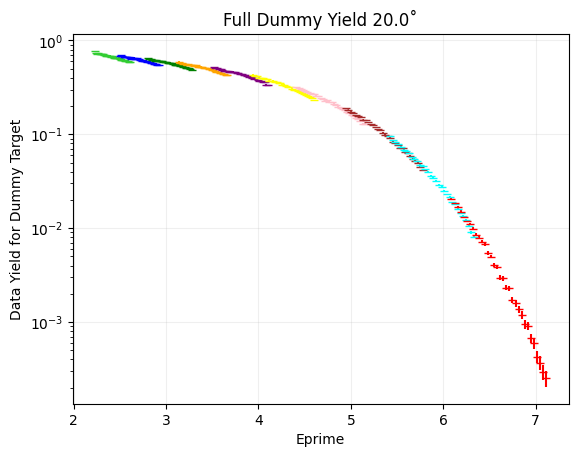

In [16]:
Z, A = 13, 27 # Target
Eu = 0.19535 # Ratio of upstream dummy to target cell thickness
Ed = 0.23924 # Ratio of downstream dummy to target cell thickness
ytar_hist = {}

for momentum in dmom:
    # Get the runs where data for Dummy target was taken
    files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in Dummy_dict[momentum]]
    # Grab relevant bracnhes. ytar needed for upstream/downstream differentiation
    branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag', 'H_gtr_y']
    electrons = uproot.concatenate(files, branches)

    data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
    dp_cut = electrons['H_gtr_dp'][data_cut]
    theta_cut = electrons['H_gtr_th'][data_cut]
    phi_cut = electrons['H_gtr_ph'][data_cut]
    y_cut = electrons['H_gtr_y'][data_cut]

    theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts)/np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
    delta_hist[momentum] = np.array(dp_cut)
    ytar_hist[momentum] = np.array(y_cut)

dummy_eprime_bin_contents_2p42, dummy_eprime_bin_errors_2p42 = datahist_from_array(delta_hist[2.42], 2.42, hsdelta_binedges, ald)
dummy_eprime_bin_contents_2p71, dummy_eprime_bin_errors_2p71 = datahist_from_array(delta_hist[2.71], 2.71, hsdelta_binedges, ald)
dummy_eprime_bin_contents_3p04, dummy_eprime_bin_errors_3p04 = datahist_from_array(delta_hist[3.04], 3.04, hsdelta_binedges, ald)
dummy_eprime_bin_contents_3p4, dummy_eprime_bin_errors_3p4 = datahist_from_array(delta_hist[3.4], 3.4, hsdelta_binedges, ald)
dummy_eprime_bin_contents_3p81, dummy_eprime_bin_errors_3p81 = datahist_from_array(delta_hist[3.81], 3.81, hsdelta_binedges, ald)
dummy_eprime_bin_contents_4p27, dummy_eprime_bin_errors_4p27 = datahist_from_array(delta_hist[4.27], 4.27, hsdelta_binedges, ald)
dummy_eprime_bin_contents_4p78, dummy_eprime_bin_errors_4p78 = datahist_from_array(delta_hist[4.78], 4.78, hsdelta_binedges, ald)
dummy_eprime_bin_contents_5p36, dummy_eprime_bin_errors_5p36 = datahist_from_array(delta_hist[5.36], 5.36, hsdelta_binedges, ald)
dummy_eprime_bin_contents_5p878, dummy_eprime_bin_errors_5p878 = datahist_from_array(delta_hist[5.878], 5.878, hsdelta_binedges, ald)
dummy_eprime_bin_contents_6p6, dummy_eprime_bin_errors_6p6 = datahist_from_array(delta_hist[6.6], 6.6, hsdelta_binedges, ald)

plt.errorbar(binned_eprime_bin_centers_2p42, dummy_eprime_bin_contents_2p42, yerr = dummy_eprime_bin_errors_2p42, fmt = '_', label = '2.42 GeV', color = 'limegreen')
plt.errorbar(binned_eprime_bin_centers_2p71, dummy_eprime_bin_contents_2p71, yerr = dummy_eprime_bin_errors_2p71, fmt = '_', label = '2.71 GeV', color = 'blue')
plt.errorbar(binned_eprime_bin_centers_3p04, dummy_eprime_bin_contents_3p04, yerr = dummy_eprime_bin_errors_3p04, fmt = '_', label = '3.04 GeV', color = 'green')
plt.errorbar(binned_eprime_bin_centers_3p4, dummy_eprime_bin_contents_3p4, yerr = dummy_eprime_bin_errors_3p4, fmt = '_', label = '3.4 GeV', color = 'orange')
plt.errorbar(binned_eprime_bin_centers_3p81, dummy_eprime_bin_contents_3p81, yerr = dummy_eprime_bin_errors_3p81, fmt = '_', label = '3.81 GeV', color = 'purple')
plt.errorbar(binned_eprime_bin_centers_4p27, dummy_eprime_bin_contents_4p27, yerr = dummy_eprime_bin_errors_4p27, fmt = '_', label = '4.27 GeV', color = 'yellow')
plt.errorbar(binned_eprime_bin_centers_4p78, dummy_eprime_bin_contents_4p78, yerr = dummy_eprime_bin_errors_4p78, fmt = '_', label = '4.78 GeV', color = 'pink')
plt.errorbar(binned_eprime_bin_centers_5p36, dummy_eprime_bin_contents_5p36, yerr = dummy_eprime_bin_errors_5p36, fmt = '_', label = '5.36 GeV', color = 'brown')
plt.errorbar(binned_eprime_bin_centers_5p878, dummy_eprime_bin_contents_5p878, yerr = dummy_eprime_bin_errors_5p878, fmt = '_', label = '5.878 GeV', color = 'cyan')
plt.errorbar(binned_eprime_bin_centers_6p6, dummy_eprime_bin_contents_6p6, yerr = dummy_eprime_bin_errors_6p6, fmt = '_', label = '6.6 GeV', color = 'red')
plt.grid(alpha = 0.2)
plt.xlabel('Eprime')
plt.ylabel('Data Yield for Dummy Target')
plt.title(f'Full {ald} Yield {dang}˚')
plt.yscale('log')

In [17]:
print(f"{dummy_eprime_bin_contents_4p27}")
print(dummy_eprime_bin_contents_2p42)

[0.43323133 0.4211672  0.41396566 0.40294791 0.39466922 0.39907016
 0.38916034 0.3883294  0.37272605 0.36687864 0.37420329 0.35970788
 0.35863072 0.3512753  0.34844392 0.33847255 0.33693376 0.32456188
 0.3160062  0.31800663 0.30603483 0.29880251 0.29609424 0.2871077
 0.28470718 0.277044   0.26885763 0.26362574 0.25605489 0.25153084
 0.24328292 0.23088026]
[0.76519557 0.73275164 0.71759925 0.72704721 0.72464065 0.71332093
 0.71064698 0.71002305 0.69273151 0.69166193 0.68052046 0.68987929
 0.68577923 0.68898797 0.6713399  0.67820304 0.66135715 0.6567223
 0.65761362 0.65012656 0.64754174 0.65565272 0.63443938 0.62035657
 0.622674   0.62124789 0.62080223 0.60146065 0.6060955  0.60422374
 0.58924961 0.5847039 ]


<h1 align="center">DATA WORK FOR DTG</h1>

In [18]:
# Kinematic variables
Z, A = target_info[dtg][0], target_info[dtg][1]  # Target
thick = target_info[dtg][2] # g/cm2. From Cameron's target sheet column 'R'
thick = thick * 0.996 # Cryo target contraction correction factor
lumin = thick * sim_charge / A * N_A / Q_E * 1e-39
ytar = {}
dtrack_hist = {}
ytar_hist = {}
for momentum in dmom:
    files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in LD2_dict[momentum]]
    branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag', 'H_dc_ntrack']
    electrons = uproot.concatenate(files, branches)

    data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
    dp_cut = electrons['H_gtr_dp'][data_cut]
    dtrack_hist[momentum] = electrons['H_dc_ntrack'][data_cut]
    delta_hist[momentum] = np.array(dp_cut)

eprime_bin_contents_2p42_dtg, eprime_bin_errors_2p42_dtg = datahist_from_array(delta_hist[2.42], 2.42, data_delta, dtg)
eprime_bin_contents_2p71_dtg, eprime_bin_errors_2p71_dtg = datahist_from_array(delta_hist[2.71], 2.71, data_delta, dtg)
eprime_bin_contents_3p04_dtg, eprime_bin_errors_3p04_dtg = datahist_from_array(delta_hist[3.04], 3.04, data_delta, dtg)
eprime_bin_contents_3p4_dtg, eprime_bin_errors_3p4_dtg = datahist_from_array(delta_hist[3.4], 3.4, data_delta, dtg)
eprime_bin_contents_3p81_dtg, eprime_bin_errors_3p81_dtg = datahist_from_array(delta_hist[3.81], 3.81, data_delta, dtg)
eprime_bin_contents_4p27_dtg, eprime_bin_errors_4p27_dtg = datahist_from_array(delta_hist[4.27], 4.27, data_delta, dtg)
eprime_bin_contents_4p78_dtg, eprime_bin_errors_4p78_dtg = datahist_from_array(delta_hist[4.78], 4.78, data_delta, dtg)
eprime_bin_contents_5p36_dtg, eprime_bin_errors_5p36_dtg = datahist_from_array(delta_hist[5.36], 5.36, data_delta, dtg)
eprime_bin_contents_5p878_dtg, eprime_bin_errors_5p878_dtg = datahist_from_array(delta_hist[5.878], 5.878, data_delta, dtg)
eprime_bin_contents_6p6_dtg, eprime_bin_errors_6p6_dtg = datahist_from_array(delta_hist[6.6], 6.6, data_delta, dtg)

Target boiling correction not applied for cryo target LD2
Mean scaling factor for LD2 at 2.42 GeV/c is 0.0011319916446440499
Total scaling factor for LD2 at 2.42 GeV/c is 1766.7974931289282
Scaling factor for LD2 at 2.42 GeV/c is 0.0005659958223220249
Counts for LD2 at 2.42 GeV is 5082
Target boiling correction not applied for cryo target LD2
Mean scaling factor for LD2 at 2.71 GeV/c is 0.0002825141761530963
Total scaling factor for LD2 at 2.71 GeV/c is 7079.290771292789
Scaling factor for LD2 at 2.71 GeV/c is 0.00014125708807654816
Counts for LD2 at 2.71 GeV is 19130
Target boiling correction not applied for cryo target LD2
Mean scaling factor for LD2 at 3.04 GeV/c is 0.00028169864256205666
Total scaling factor for LD2 at 3.04 GeV/c is 7099.785720690546
Scaling factor for LD2 at 3.04 GeV/c is 0.00014084932128102833
Counts for LD2 at 3.04 GeV is 17818
Target boiling correction not applied for cryo target LD2
Mean scaling factor for LD2 at 3.4 GeV/c is 0.00013783006018062868
Total scali

Target boiling correction not applied for cryo target LD2
Mean scaling factor for LD2 at 4.27 GeV/c is 4.260977512734653e-05
Total scaling factor for LD2 at 4.27 GeV/c is 23468.793182112102
Scaling factor for LD2 at 4.27 GeV/c is 4.260977512734653e-05
Counts for LD2 at 4.27 GeV is 40738
Target boiling correction not applied for cryo target LD2
Mean scaling factor for LD2 at 4.78 GeV/c is 1.8204487288213947e-05
Total scaling factor for LD2 at 4.78 GeV/c is 109863.02268973274
Scaling factor for LD2 at 4.78 GeV/c is 9.102243644106974e-06
Counts for LD2 at 4.78 GeV is 142628


Target boiling correction not applied for cryo target LD2
Mean scaling factor for LD2 at 5.36 GeV/c is 4.072277540506232e-05
Total scaling factor for LD2 at 5.36 GeV/c is 49112.566128078215
Scaling factor for LD2 at 5.36 GeV/c is 2.036138770253116e-05
Counts for LD2 at 5.36 GeV is 39287
Target boiling correction not applied for cryo target LD2
Mean scaling factor for LD2 at 5.878 GeV/c is 1.1909888262267445e-05
Total scaling factor for LD2 at 5.878 GeV/c is 503783.0639443547
Scaling factor for LD2 at 5.878 GeV/c is 1.9849813770445744e-06
Counts for LD2 at 5.878 GeV is 196498
Target boiling correction not applied for cryo target LD2
Mean scaling factor for LD2 at 6.6 GeV/c is 1.0982433257160586e-05
Total scaling factor for LD2 at 6.6 GeV/c is 455272.51410701557
Scaling factor for LD2 at 6.6 GeV/c is 2.1964866514321173e-06
Counts for LD2 at 6.6 GeV is 31126


1.0 50.0


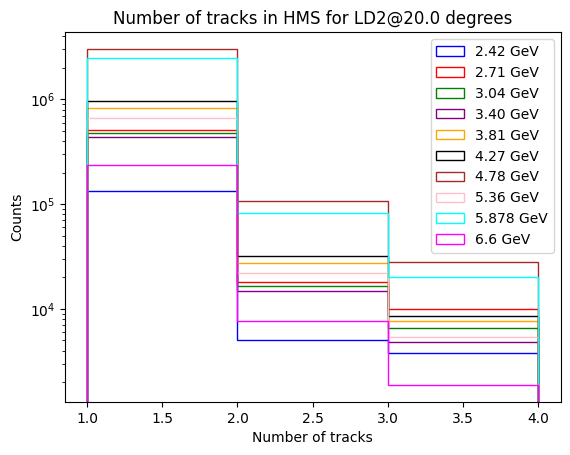

In [19]:
plt.hist(dtrack_hist[2.42], bins = range(1, 5), histtype = 'step', label = '2.42 GeV', color = 'blue')
plt.hist(dtrack_hist[2.71], bins = range(1, 5), histtype = 'step', label = '2.71 GeV', color = 'red')
plt.hist(dtrack_hist[3.04], bins = range(1, 5), histtype = 'step', label = '3.04 GeV', color = 'green')
plt.hist(dtrack_hist[3.40], bins = range(1, 5), histtype = 'step', label = '3.40 GeV', color = 'purple')
plt.hist(dtrack_hist[3.81], bins = range(1, 5), histtype = 'step', label = '3.81 GeV', color = 'orange')
plt.hist(dtrack_hist[4.27], bins = range(1, 5), histtype = 'step', label = '4.27 GeV', color = 'black')
plt.hist(dtrack_hist[4.78], bins = range(1, 5), histtype = 'step', label = '4.78 GeV', color = 'brown')
plt.hist(dtrack_hist[5.36], bins = range(1, 5), histtype = 'step', label = '5.36 GeV', color = 'pink')
plt.hist(dtrack_hist[5.878], bins = range(1, 5), histtype = 'step', label = '5.878 GeV', color = 'cyan')
plt.hist(dtrack_hist[6.6], bins = range(1, 5), histtype = 'step', label = '6.6 GeV', color = 'magenta')
plt.yscale('log')
plt.legend()
plt.ylabel('Counts')
plt.xlabel('Number of tracks')
plt.title(f'Number of tracks in HMS for {dtg}@{dang} degrees')
# plt.savefig(f'{folder}/track_hist_{time.time():.0f}.pdf')
kam = np.min(dtrack_hist[2.42])
bada = np.max(dtrack_hist[2.42])
print(kam, bada)

[2.87639077 2.78639743 2.81582922 2.74281575 2.74677773 2.72640188
 2.70602603 2.6828202  2.6964041  2.67716024 2.76771957 2.65338842
 2.56679105 2.53849126 2.58886489 2.57131902 2.56792305 2.57131902
 2.48358967 2.52773734 2.50113554 2.47566573 2.41793415 2.40548224
 2.39699231 2.30643298 2.35624061 2.30133901 2.29737704 2.24304144
 2.29341507 2.29341507]
[0.06836784 0.0605813  0.05338561 0.04771208 0.04174203 0.03661104
 0.03248384 0.02868172 0.02524642 0.02196926 0.01947405 0.01680752
 0.01443311 0.01237061 0.01095388 0.00916594 0.00753175 0.00654773
 0.00508487 0.00411402 0.00346825 0.00258746 0.00213718 0.00148922
 0.00116194 0.00099501 0.00070947 0.00059744 0.00049201 0.00036022
 0.0003141  0.00023942]


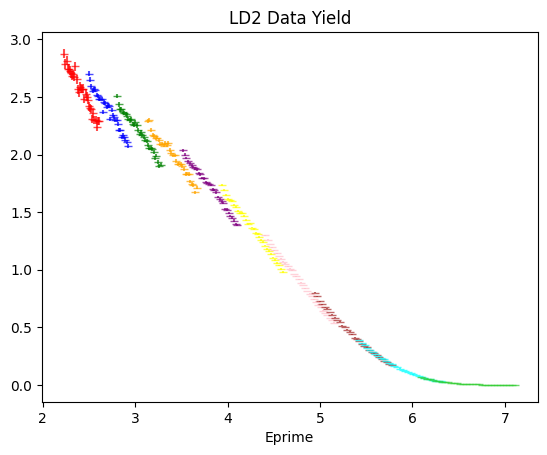

In [20]:
fig3, ax3 = plt.subplots()
ax3.errorbar(binned_eprime_bin_centers_2p42, eprime_bin_contents_2p42_dtg, yerr = eprime_bin_errors_2p42_dtg, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV')
ax3.errorbar(binned_eprime_bin_centers_2p71, eprime_bin_contents_2p71_dtg, yerr = eprime_bin_errors_2p71_dtg, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p04, eprime_bin_contents_3p04_dtg, yerr = eprime_bin_errors_3p04_dtg, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p4, eprime_bin_contents_3p4_dtg, yerr = eprime_bin_errors_3p4_dtg, fmt = '_', color = 'orange', alpha = 0.7, label = '3.4 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p81, eprime_bin_contents_3p81_dtg, yerr = eprime_bin_errors_3p81_dtg, fmt = '_', color = 'purple', alpha = 0.7, label = '3.81 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p27, eprime_bin_contents_4p27_dtg, yerr = eprime_bin_errors_4p27_dtg, fmt = '_', color = 'yellow', alpha = 0.7, label = '4.27 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p78, eprime_bin_contents_4p78_dtg, yerr = eprime_bin_errors_4p78_dtg, fmt = '_', color = 'pink', alpha = 0.7, label = '4.78 GeV')
ax3.errorbar(binned_eprime_bin_centers_5p36, eprime_bin_contents_5p36_dtg, yerr = eprime_bin_errors_5p36_dtg, fmt = '_', color = 'brown', alpha = 0.7, label = '5.36 GeV')
ax3.errorbar(binned_eprime_bin_centers_5p878, eprime_bin_contents_5p878_dtg, yerr = eprime_bin_errors_5p878_dtg, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
ax3.errorbar(binned_eprime_bin_centers_6p6, eprime_bin_contents_6p6_dtg, yerr = eprime_bin_errors_6p6_dtg, fmt = '_', color = 'limegreen', alpha = 0.7, label = '6.6 GeV')
ax3.set_xlabel('Eprime')
ax3.set_title('LD2 Data Yield')
print(eprime_bin_contents_2p42_dtg)
print(eprime_bin_contents_6p6_dtg)

<h2 style="text-align: center; color: silver">Subtracting CSB from full cryo target yield and dummy</h2>

Text(0.5, 1.0, 'Dummy Subtracted LD2 Data Yield')

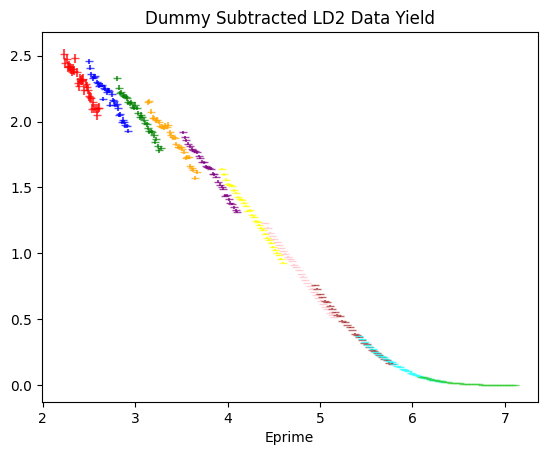

In [21]:
# Calculate the charge symmetric background fraction per bin for full cryo target
csb_frac_2p42_dtg = csb(binned_eprime_bin_centers_2p42, dtg, dang)
csb_frac_2p71_dtg = csb(binned_eprime_bin_centers_2p71, dtg, dang)
csb_frac_3p04_dtg = csb(binned_eprime_bin_centers_3p04, dtg, dang)
csb_frac_3p4_dtg = csb(binned_eprime_bin_centers_3p4, dtg, dang)
csb_frac_3p81_dtg = csb(binned_eprime_bin_centers_3p81, dtg, dang)
csb_frac_4p27_dtg = csb(binned_eprime_bin_centers_4p27, dtg, dang)
csb_frac_4p78_dtg = csb(binned_eprime_bin_centers_4p78, dtg, dang)
csb_frac_5p36_dtg = csb(binned_eprime_bin_centers_5p36, dtg, dang)
csb_frac_5p878_dtg = csb(binned_eprime_bin_centers_5p878, dtg, dang)
csb_frac_6p6_dtg = csb(binned_eprime_bin_centers_6p6, dtg, dang)

# Calculate the charge symmetric background fraction per bin for dummy target
csb_frac_2p42_ald = csb(binned_eprime_bin_centers_2p42, ald, dang)
csb_frac_2p71_ald = csb(binned_eprime_bin_centers_2p71, ald, dang)
csb_frac_3p04_ald = csb(binned_eprime_bin_centers_3p04, ald, dang)
csb_frac_3p4_ald = csb(binned_eprime_bin_centers_3p4, ald, dang)
csb_frac_3p81_ald = csb(binned_eprime_bin_centers_3p81, ald, dang)
csb_frac_4p27_ald = csb(binned_eprime_bin_centers_4p27, ald, dang)
csb_frac_4p78_ald = csb(binned_eprime_bin_centers_4p78, ald, dang)
csb_frac_5p36_ald = csb(binned_eprime_bin_centers_5p36, ald, dang)
csb_frac_5p878_ald = csb(binned_eprime_bin_centers_5p878, ald, dang)
csb_frac_6p6_ald = csb(binned_eprime_bin_centers_6p6, ald, dang)

fig4, ax4 = plt.subplots()
# Perform CSB subtraction on dummy target
subtracted_bin_contents_2p42_ald = dummy_eprime_bin_contents_2p42 * (1 - csb_frac_2p42_ald)
subtracted_bin_contents_2p71_ald = dummy_eprime_bin_contents_2p71 * (1 - csb_frac_2p71_ald)
subtracted_bin_contents_3p04_ald = dummy_eprime_bin_contents_3p04 * (1 - csb_frac_3p04_ald)
subtracted_bin_contents_3p4_ald = dummy_eprime_bin_contents_3p4 * (1 - csb_frac_3p4_ald)
subtracted_bin_contents_3p81_ald = dummy_eprime_bin_contents_3p81 * (1 - csb_frac_3p81_ald)
subtracted_bin_contents_4p27_ald = dummy_eprime_bin_contents_4p27 * (1 - csb_frac_4p27_ald)
subtracted_bin_contents_4p78_ald = dummy_eprime_bin_contents_4p78 * (1 - csb_frac_4p78_ald)
subtracted_bin_contents_5p36_ald = dummy_eprime_bin_contents_5p36 * (1 - csb_frac_5p36_ald)
subtracted_bin_contents_5p878_ald = dummy_eprime_bin_contents_5p878 * (1 - csb_frac_5p878_ald)
subtracted_bin_contents_6p6_ald = dummy_eprime_bin_contents_6p6 * (1 - csb_frac_6p6_ald)

subtracted_bin_errors_2p42_ald = dummy_eprime_bin_errors_2p42 * (1 - csb_frac_2p42_ald)
subtracted_bin_errors_2p71_ald = dummy_eprime_bin_errors_2p71 * (1 - csb_frac_2p71_ald)
subtracted_bin_errors_3p04_ald = dummy_eprime_bin_errors_3p04 * (1 - csb_frac_3p04_ald)
subtracted_bin_errors_3p4_ald = dummy_eprime_bin_errors_3p4 * (1 - csb_frac_3p4_ald)
subtracted_bin_errors_3p81_ald = dummy_eprime_bin_errors_3p81 * (1 - csb_frac_3p81_ald)
subtracted_bin_errors_4p27_ald = dummy_eprime_bin_errors_4p27 * (1 - csb_frac_4p27_ald)
subtracted_bin_errors_4p78_ald = dummy_eprime_bin_errors_4p78 * (1 - csb_frac_4p78_ald)
subtracted_bin_errors_5p36_ald = dummy_eprime_bin_errors_5p36 * (1 - csb_frac_5p36_ald)
subtracted_bin_errors_5p878_ald = dummy_eprime_bin_errors_5p878 * (1 - csb_frac_5p878_ald)
subtracted_bin_errors_6p6_ald = dummy_eprime_bin_errors_6p6 * (1 - csb_frac_6p6_ald)

# Subtract the charge symmetric background fraction from the full cryo yield
subtracted_bin_contents_2p42_dtg = eprime_bin_contents_2p42_dtg * (1 - csb_frac_2p42_dtg)
subtracted_bin_contents_2p71_dtg = eprime_bin_contents_2p71_dtg * (1 - csb_frac_2p71_dtg)
subtracted_bin_contents_3p04_dtg = eprime_bin_contents_3p04_dtg * (1 - csb_frac_3p04_dtg)
subtracted_bin_contents_3p4_dtg = eprime_bin_contents_3p4_dtg * (1 - csb_frac_3p4_dtg)
subtracted_bin_contents_3p81_dtg = eprime_bin_contents_3p81_dtg * (1 - csb_frac_3p81_dtg)
subtracted_bin_contents_4p27_dtg = eprime_bin_contents_4p27_dtg * (1 - csb_frac_4p27_dtg)
subtracted_bin_contents_4p78_dtg = eprime_bin_contents_4p78_dtg * (1 - csb_frac_4p78_dtg)
subtracted_bin_contents_5p36_dtg = eprime_bin_contents_5p36_dtg * (1 - csb_frac_5p36_dtg)
subtracted_bin_contents_5p878_dtg = eprime_bin_contents_5p878_dtg * (1 - csb_frac_5p878_dtg)
subtracted_bin_contents_6p6_dtg = eprime_bin_contents_6p6_dtg * (1 - csb_frac_6p6_dtg)

subtracted_bin_errors_2p42_dtg = eprime_bin_errors_2p42_dtg * (1 - csb_frac_2p42_dtg)
subtracted_bin_errors_2p71_dtg = eprime_bin_errors_2p71_dtg * (1 - csb_frac_2p71_dtg)
subtracted_bin_errors_3p04_dtg = eprime_bin_errors_3p04_dtg * (1 - csb_frac_3p04_dtg)
subtracted_bin_errors_3p4_dtg = eprime_bin_errors_3p4_dtg * (1 - csb_frac_3p4_dtg)
subtracted_bin_errors_3p81_dtg = eprime_bin_errors_3p81_dtg * (1 - csb_frac_3p81_dtg)
subtracted_bin_errors_4p27_dtg = eprime_bin_errors_4p27_dtg * (1 - csb_frac_4p27_dtg)
subtracted_bin_errors_4p78_dtg = eprime_bin_errors_4p78_dtg * (1 - csb_frac_4p78_dtg)
subtracted_bin_errors_5p36_dtg = eprime_bin_errors_5p36_dtg * (1 - csb_frac_5p36_dtg)
subtracted_bin_errors_5p878_dtg = eprime_bin_errors_5p878_dtg * (1 - csb_frac_5p878_dtg)
subtracted_bin_errors_6p6_dtg = eprime_bin_errors_6p6_dtg * (1 - csb_frac_6p6_dtg)

# Perform Dummy Subtraction
subtracted_bin_contents_2p42_dtg = subtracted_bin_contents_2p42_dtg - (E * subtracted_bin_contents_2p42_ald)
subtracted_bin_contents_2p71_dtg = subtracted_bin_contents_2p71_dtg - (E * subtracted_bin_contents_2p71_ald)
subtracted_bin_contents_3p04_dtg = subtracted_bin_contents_3p04_dtg - (E * subtracted_bin_contents_3p04_ald)
subtracted_bin_contents_3p4_dtg = subtracted_bin_contents_3p4_dtg - (E * subtracted_bin_contents_3p4_ald)
subtracted_bin_contents_3p81_dtg = subtracted_bin_contents_3p81_dtg - (E * subtracted_bin_contents_3p81_ald)
subtracted_bin_contents_4p27_dtg = subtracted_bin_contents_4p27_dtg - (E * subtracted_bin_contents_4p27_ald)
subtracted_bin_contents_4p78_dtg = subtracted_bin_contents_4p78_dtg - (E * subtracted_bin_contents_4p78_ald)
subtracted_bin_contents_5p36_dtg = subtracted_bin_contents_5p36_dtg - (E * subtracted_bin_contents_5p36_ald)
subtracted_bin_contents_5p878_dtg = subtracted_bin_contents_5p878_dtg - (E * subtracted_bin_contents_5p878_ald)
subtracted_bin_contents_6p6_dtg = subtracted_bin_contents_6p6_dtg - (E * subtracted_bin_contents_6p6_ald)

# Error Prpoagation
eprime_bin_errors_2p42_dtg = np.sqrt((subtracted_bin_errors_2p42_dtg)**2 + (E * subtracted_bin_errors_2p42_ald)**2)
eprime_bin_errors_2p71_dtg = np.sqrt((subtracted_bin_errors_2p71_dtg)**2 + (E * subtracted_bin_errors_2p71_ald)**2)
eprime_bin_errors_3p04_dtg = np.sqrt((subtracted_bin_errors_3p04_dtg)**2 + (E * subtracted_bin_errors_3p04_ald)**2)
eprime_bin_errors_3p4_dtg = np.sqrt((subtracted_bin_errors_3p4_dtg)**2 + (E * subtracted_bin_errors_3p4_ald)**2)
eprime_bin_errors_3p81_dtg = np.sqrt((subtracted_bin_errors_3p81_dtg)**2 + (E * subtracted_bin_errors_3p81_ald)**2)
eprime_bin_errors_4p27_dtg = np.sqrt((subtracted_bin_errors_4p27_dtg)**2 + (E * subtracted_bin_errors_4p27_ald)**2)
eprime_bin_errors_4p78_dtg = np.sqrt((subtracted_bin_errors_4p78_dtg)**2 + (E * subtracted_bin_errors_4p78_ald)**2)
eprime_bin_errors_5p36_dtg = np.sqrt((subtracted_bin_errors_5p36_dtg)**2 + (E * subtracted_bin_errors_5p36_ald)**2)
eprime_bin_errors_5p878_dtg = np.sqrt((subtracted_bin_errors_5p878_dtg)**2 + (E * subtracted_bin_errors_5p878_ald)**2)
eprime_bin_errors_6p6_dtg = np.sqrt((subtracted_bin_errors_6p6_dtg)**2 + (E * subtracted_bin_errors_6p6_ald)**2)

ax4.errorbar(binned_eprime_bin_centers_2p42, subtracted_bin_contents_2p42_dtg, yerr = subtracted_bin_errors_2p42_dtg, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV')
ax4.errorbar(binned_eprime_bin_centers_2p71, subtracted_bin_contents_2p71_dtg, yerr = subtracted_bin_errors_2p71_dtg, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p04, subtracted_bin_contents_3p04_dtg, yerr = subtracted_bin_errors_3p04_dtg, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p4, subtracted_bin_contents_3p4_dtg, yerr = subtracted_bin_errors_3p4_dtg, fmt = '_', color = 'orange', alpha = 0.7, label = '3.4 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p81, subtracted_bin_contents_3p81_dtg, yerr = subtracted_bin_errors_3p81_dtg, fmt = '_', color = 'purple', alpha = 0.7, label = '3.81 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p27, subtracted_bin_contents_4p27_dtg, yerr = subtracted_bin_errors_4p27_dtg, fmt = '_', color = 'yellow', alpha = 0.7, label = '4.27 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p78, subtracted_bin_contents_4p78_dtg, yerr = subtracted_bin_errors_4p78_dtg, fmt = '_', color = 'pink', alpha = 0.7, label = '4.78 GeV')
ax4.errorbar(binned_eprime_bin_centers_5p36, subtracted_bin_contents_5p36_dtg, yerr = subtracted_bin_errors_5p36_dtg, fmt = '_', color = 'brown', alpha = 0.7, label = '5.36 GeV')
ax4.errorbar(binned_eprime_bin_centers_5p878, subtracted_bin_contents_5p878_dtg, yerr = subtracted_bin_errors_5p878_dtg, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
ax4.errorbar(binned_eprime_bin_centers_6p6, subtracted_bin_contents_6p6_dtg, yerr = subtracted_bin_errors_6p6_dtg, fmt = '_', color = 'limegreen', alpha = 0.7, label = '6.6 GeV')
# ax4.set_yscale('log')
ax4.set_xlabel('Eprime')
ax4.set_title('Dummy Subtracted LD2 Data Yield')

<h1 align="center">SIMULATION WORK FOR DTG</h1>


In [22]:
# Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor(f"/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/{xsec_tables}/xem2_emc_rc_d2cryo22_hms.out")

# If using the old mc files
# dpp_up, dpp_down = 15.0, -15.0 # Momentum acceptance upper and lower limit
# for momentum in dmom:
#     ep_min[momentum] = momentum * (1 + 0.01 * dpp_down)
#     ep_max[momentum] = momentum * (1 + 0.01 * dpp_up)
#     phi_up, phi_down, theta_up, theta_down = 110.0, -110.0, 65.0, -65.0 # mrad
#     domega = (phi_up - phi_down) * (theta_up - theta_down) / 1e6  # diff solid angle in sr
#     sim_charge = 1.
#     wall_exit, wall_ent = 0.0168, 0.02024 # in cm
#     dum_thick_exit, dum_thick_ent = 0.1816, 0.1815 # g/cm2
#     lumin = thick * sim_charge / A * N_A / Q_E * 1e-39

ytar_weight = {}
ytarcut = {}
jacobian_weight = {}
for momentum in dmom:
    mom_str = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
    # filepath = f"/Volumes/smriti/xem2/worksim_old/hms_mc_{dsimstring}_20degm{mom_str}.root"
    filepath = f"/Volumes/smriti/xem2/worksim/hms_{idang}deg_{mom_str}gev_{dsimstring}.root"

    # Open the file and tree
    file = uproot.open(filepath)
    # tree = file["h1"]
    tree = file["h10"]

    # Load the branches
    electrons = tree.arrays(["hsdeltai", "hsytar", "hsyptari", "hsxptari", "stop_id"], library = 'np')    
    nentries = len(electrons["hsdeltai"])

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdeltai"]) < 8) & \
            (np.abs(electrons["hsyptari"]) < 0.032) & \
            (np.abs(electrons["hsxptari"]) < 0.085) & \
            (electrons["stop_id"] == 0)
    
    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdeltai"][mc_cut]
    hsyptar_cut = electrons["hsyptari"][mc_cut]
    hsxptar_cut = electrons["hsxptari"][mc_cut]
    hsytar_cut = electrons["hsytar"][mc_cut]

    delta_dict[momentum] = hsdelta_cut
    Eprime_dict[momentum] = momentum * (1 + 0.01 * hsdelta_cut)

    delta_weight[momentum] = delta_correction(hsdelta_cut)

    # Calculate the ytar acceptance correction factor
    ytar_weight[momentum] = -0.00812174 * hsytar_cut**2 - 0.0000415678 * hsytar_cut + 1.00021
    ytarcut[momentum] = hsytar_cut

    # MC Jacobian
    jacobian_weight[momentum] = np.power((1 + np.power(hsxptar_cut, 2) + np.power(hsyptar_cut, 2)), 1.5)

    # print("Length of ytar_weight", len(ytar_weight))
    # print("Length of Eprime_dict", len(Eprime_dict[momentum]))
    
    # Calculate theta (in degrees)
    thetarad = np.arccos((cos_ts + hsyptar_cut * sin_ts) / np.sqrt(1 + hsxptar_cut * hsxptar_cut + hsyptar_cut * hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)
    
    # Perform the interpolation
    points_dtg = np.array([V2, V3]).T # Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))  # Make a column stack of points to be interpolated for our given E' and theta
    xsec_array[momentum] = griddata(points_dtg, V9, points_to_interpolate, method = 'linear') # Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section(V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
    mc_scale[momentum] = lumin * domega * (ep_max[momentum] - ep_min[momentum]) / nentries         # Calculate the scale for simulation

hsdelta_min = np.min(delta_dict[2.42])
hsdelta_max = np.max(delta_dict[2.42])
print("Should be -8 and +8", hsdelta_min, hsdelta_max)
hsdelta_num_bins = bin_per_mom
hsdelta_binedges = np.linspace(hsdelta_min, hsdelta_max, hsdelta_num_bins + 1)

bin_counts_eprime_2p42_dtg, bin_errors_eprime_2p42_dtg = mchist_from_array(delta_dict[2.42], xsec_array[2.42] * mc_scale[2.42] * ytar_weight[2.42] * jacobian_weight[2.42] * delta_weight[2.42], hsdelta_binedges)
bin_counts_eprime_2p71_dtg, bin_errors_eprime_2p71_dtg = mchist_from_array(delta_dict[2.71], xsec_array[2.71] * mc_scale[2.71] * ytar_weight[2.71] * jacobian_weight[2.71] * delta_weight[2.71], hsdelta_binedges)
bin_counts_eprime_3p04_dtg, bin_errors_eprime_3p04_dtg = mchist_from_array(delta_dict[3.04], xsec_array[3.04] * mc_scale[3.04] * ytar_weight[3.04] * jacobian_weight[3.04] * delta_weight[3.04], hsdelta_binedges)
bin_counts_eprime_3p4_dtg, bin_errors_eprime_3p4_dtg = mchist_from_array(delta_dict[3.4], xsec_array[3.4] * mc_scale[3.4] * ytar_weight[3.4] * jacobian_weight[3.4] * delta_weight[3.4], hsdelta_binedges)
bin_counts_eprime_3p81_dtg, bin_errors_eprime_3p81_dtg = mchist_from_array(delta_dict[3.81], xsec_array[3.81] * mc_scale[3.81] * ytar_weight[3.81] * jacobian_weight[3.81] * delta_weight[3.81], hsdelta_binedges)
bin_counts_eprime_4p27_dtg, bin_errors_eprime_4p27_dtg = mchist_from_array(delta_dict[4.27], xsec_array[4.27] * mc_scale[4.27] * ytar_weight[4.27] * jacobian_weight[4.27] * delta_weight[4.27], hsdelta_binedges)
bin_counts_eprime_4p78_dtg, bin_errors_eprime_4p78_dtg = mchist_from_array(delta_dict[4.78], xsec_array[4.78] * mc_scale[4.78] * ytar_weight[4.78] * jacobian_weight[4.78] * delta_weight[4.78], hsdelta_binedges)
bin_counts_eprime_5p36_dtg, bin_errors_eprime_5p36_dtg = mchist_from_array(delta_dict[5.36], xsec_array[5.36] * mc_scale[5.36] * ytar_weight[5.36] * jacobian_weight[5.36] * delta_weight[5.36], hsdelta_binedges)
bin_counts_eprime_5p878_dtg, bin_errors_eprime_5p878_dtg = mchist_from_array(delta_dict[5.878], xsec_array[5.878] * mc_scale[5.878] * ytar_weight[5.878] * jacobian_weight[5.878] * delta_weight[5.878], hsdelta_binedges)
bin_counts_eprime_6p6_dtg, bin_errors_eprime_6p6_dtg = mchist_from_array(delta_dict[6.6], xsec_array[6.6] * mc_scale[6.6] * ytar_weight[6.6] * jacobian_weight[6.6] * delta_weight[6.6], hsdelta_binedges)

Should be -8 and +8 -7.999999206047505 7.999991373624653


Text(0.5, 1.0, 'LD2@20.0˚')

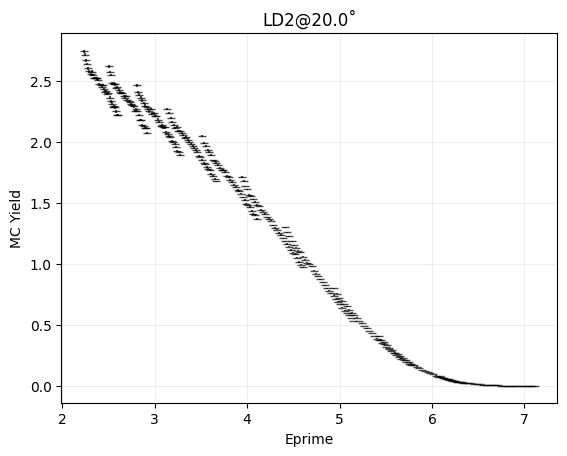

In [23]:
fig4, ax4 = plt.subplots()
# Plotting the histogram with error bars
ax4.errorbar(binned_eprime_bin_centers_2p42, bin_counts_eprime_2p42_dtg, yerr = bin_errors_eprime_2p42_dtg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.42 GeV')
ax4.errorbar(binned_eprime_bin_centers_2p71, bin_counts_eprime_2p71_dtg, yerr = bin_errors_eprime_2p71_dtg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.71 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p04, bin_counts_eprime_3p04_dtg, yerr = bin_errors_eprime_3p04_dtg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 3.04 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p4, bin_counts_eprime_3p4_dtg, yerr = bin_errors_eprime_3p4_dtg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 3.4 GeV')
ax4.errorbar(binned_eprime_bin_centers_3p81, bin_counts_eprime_3p81_dtg, yerr = bin_errors_eprime_3p81_dtg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 3.81 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p27, bin_counts_eprime_4p27_dtg, yerr = bin_errors_eprime_4p27_dtg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 4.27 GeV')
ax4.errorbar(binned_eprime_bin_centers_4p78, bin_counts_eprime_4p78_dtg, yerr = bin_errors_eprime_4p78_dtg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 4.78 GeV')
ax4.errorbar(binned_eprime_bin_centers_5p36, bin_counts_eprime_5p36_dtg, yerr = bin_errors_eprime_5p36_dtg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 5.36 GeV')
ax4.errorbar(binned_eprime_bin_centers_5p878, bin_counts_eprime_5p878_dtg, yerr = bin_errors_eprime_5p878_dtg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 5.878 GeV')
ax4.errorbar(binned_eprime_bin_centers_6p6, bin_counts_eprime_6p6_dtg, yerr = bin_errors_eprime_6p6_dtg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 6.6 GeV')
ax4.grid(alpha = 0.2)
ax4.set_xlabel('Eprime')
ax4.set_ylabel('MC Yield')
# ax4.set_yscale('log')
# ax4.legend() 
ax4.set_title(f'{dtg}@{dang}˚')
# fig4.savefig(f'{folder}/eprime_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR DTG</h1>

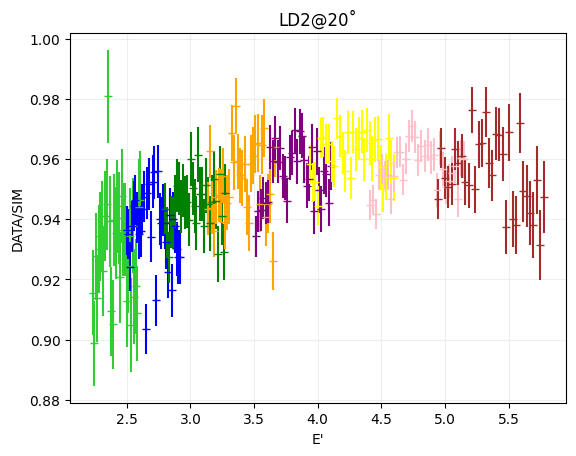

In [24]:
ratio_eprime_2p42_dtg = subtracted_bin_contents_2p42_dtg / bin_counts_eprime_2p42_dtg
ratio_eprime_2p71_dtg = subtracted_bin_contents_2p71_dtg / bin_counts_eprime_2p71_dtg
ratio_eprime_3p04_dtg = subtracted_bin_contents_3p04_dtg / bin_counts_eprime_3p04_dtg
ratio_eprime_3p4_dtg = subtracted_bin_contents_3p4_dtg / bin_counts_eprime_3p4_dtg
ratio_eprime_3p81_dtg = subtracted_bin_contents_3p81_dtg / bin_counts_eprime_3p81_dtg
ratio_eprime_4p27_dtg = subtracted_bin_contents_4p27_dtg / bin_counts_eprime_4p27_dtg
ratio_eprime_4p78_dtg = subtracted_bin_contents_4p78_dtg / bin_counts_eprime_4p78_dtg
ratio_eprime_5p36_dtg = subtracted_bin_contents_5p36_dtg / bin_counts_eprime_5p36_dtg
ratio_eprime_5p878_dtg = subtracted_bin_contents_5p878_dtg / bin_counts_eprime_5p878_dtg
ratio_eprime_6p6_dtg = subtracted_bin_contents_6p6_dtg / bin_counts_eprime_6p6_dtg

# Add errors in quadrature
ratio_errors_2p42_dtg = ratio_eprime_2p42_dtg * np.sqrt((subtracted_bin_errors_2p42_dtg / subtracted_bin_contents_2p42_dtg)**2 + (bin_errors_eprime_2p42_dtg / bin_counts_eprime_2p42_dtg)**2)
ratio_errors_2p71_dtg = ratio_eprime_2p71_dtg * np.sqrt((subtracted_bin_errors_2p71_dtg / subtracted_bin_contents_2p71_dtg)**2 + (bin_errors_eprime_2p71_dtg / bin_counts_eprime_2p71_dtg)**2)
ratio_errors_3p04_dtg = ratio_eprime_3p04_dtg * np.sqrt((subtracted_bin_errors_3p04_dtg / subtracted_bin_contents_3p04_dtg)**2 + (bin_errors_eprime_3p04_dtg / bin_counts_eprime_3p04_dtg)**2)
ratio_errors_3p4_dtg = ratio_eprime_3p4_dtg * np.sqrt((subtracted_bin_errors_3p4_dtg / subtracted_bin_contents_3p4_dtg)**2 + (bin_errors_eprime_3p4_dtg / bin_counts_eprime_3p4_dtg)**2)
ratio_errors_3p81_dtg = ratio_eprime_3p81_dtg * np.sqrt((subtracted_bin_errors_3p81_dtg / subtracted_bin_contents_3p81_dtg)**2 + (bin_errors_eprime_3p81_dtg / bin_counts_eprime_3p81_dtg)**2)
ratio_errors_4p27_dtg = ratio_eprime_4p27_dtg * np.sqrt((subtracted_bin_errors_4p27_dtg / subtracted_bin_contents_4p27_dtg)**2 + (bin_errors_eprime_4p27_dtg / bin_counts_eprime_4p27_dtg)**2)
ratio_errors_4p78_dtg = ratio_eprime_4p78_dtg * np.sqrt((subtracted_bin_errors_4p78_dtg / subtracted_bin_contents_4p78_dtg)**2 + (bin_errors_eprime_4p78_dtg / bin_counts_eprime_4p78_dtg)**2)
ratio_errors_5p36_dtg = ratio_eprime_5p36_dtg * np.sqrt((subtracted_bin_errors_5p36_dtg / subtracted_bin_contents_5p36_dtg)**2 + (bin_errors_eprime_5p36_dtg / bin_counts_eprime_5p36_dtg)**2)
ratio_errors_5p878_dtg = ratio_eprime_5p878_dtg * np.sqrt((subtracted_bin_errors_5p878_dtg / subtracted_bin_contents_5p878_dtg)**2 + (bin_errors_eprime_5p878_dtg / bin_counts_eprime_5p878_dtg)**2)
ratio_errors_6p6_dtg = ratio_eprime_6p6_dtg * np.sqrt((subtracted_bin_errors_6p6_dtg / subtracted_bin_contents_6p6_dtg)**2 + (bin_errors_eprime_6p6_dtg / bin_counts_eprime_6p6_dtg)**2)

fig5, ax5 = plt.subplots()
ax5.errorbar(binned_eprime_bin_centers_2p42, ratio_eprime_2p42_dtg, yerr = ratio_errors_2p42_dtg, fmt = '_', color = 'limegreen', label = '2.42 GeV')
ax5.errorbar(binned_eprime_bin_centers_2p71, ratio_eprime_2p71_dtg, yerr = ratio_errors_2p71_dtg, fmt = '_', color = 'blue', label = '2.71 GeV')
ax5.errorbar(binned_eprime_bin_centers_3p04, ratio_eprime_3p04_dtg, yerr = ratio_errors_3p04_dtg, fmt = '_', color = 'green', label = '3.04 GeV')
ax5.errorbar(binned_eprime_bin_centers_3p4, ratio_eprime_3p4_dtg, yerr = ratio_errors_3p4_dtg, fmt = '_', color = 'orange', label = '3.4 GeV')
ax5.errorbar(binned_eprime_bin_centers_3p81, ratio_eprime_3p81_dtg, yerr = ratio_errors_3p81_dtg, fmt = '_', color = 'purple', label = '3.81 GeV')
ax5.errorbar(binned_eprime_bin_centers_4p27, ratio_eprime_4p27_dtg, yerr = ratio_errors_4p27_dtg, fmt = '_', color = 'yellow', label = '4.27 GeV')
ax5.errorbar(binned_eprime_bin_centers_4p78, ratio_eprime_4p78_dtg, yerr = ratio_errors_4p78_dtg, fmt = '_', color = 'pink', label = '4.78 GeV')
ax5.errorbar(binned_eprime_bin_centers_5p36, ratio_eprime_5p36_dtg, yerr = ratio_errors_5p36_dtg, fmt = '_', color = 'brown', label = '5.36 GeV')
# ax5.errorbar(binned_eprime_bin_centers_5p878, ratio_eprime_5p878_dtg, yerr = ratio_errors_5p878_dtg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
# ax5.errorbar(binned_eprime_bin_centers_6p6, ratio_eprime_6p6_dtg, yerr = ratio_errors_6p6_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax5.set_xlabel('E\'')
ax5.set_ylabel('DATA/SIM')
ax5.set_title(f'{dtg}@{idang}˚')
# ax5.set_ylim(0.9, 1.1)
ax5.grid(alpha = 0.2)
# fig5.savefig(f'{folder}/ratio_eprime_{dtg}_{dang}_{folder}_{start_time:.0f}.pdf')

<h1 align="center">BORN CROSS SECTION CALCULATION FOR DTG</h1>

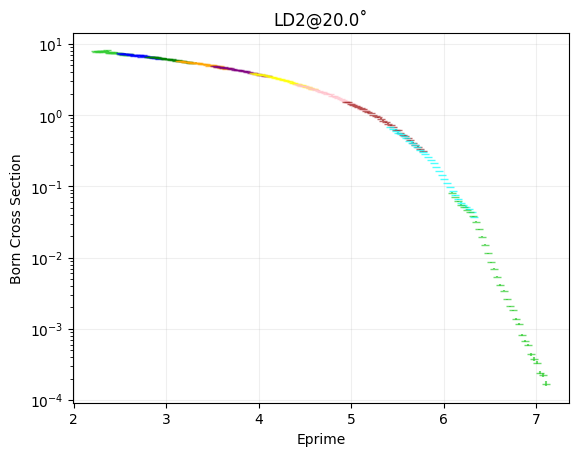

In [25]:
# Interpolate again to get model Born cross-section
born_xsec_array_2p42_dtg = griddata(points_dtg, V6, points_to_interpolate_2p42, method = 'linear')
born_xsec_array_2p71_dtg = griddata(points_dtg, V6, points_to_interpolate_2p71, method = 'linear')
born_xsec_array_3p04_dtg = griddata(points_dtg, V6, points_to_interpolate_3p04, method = 'linear')
born_xsec_array_3p4_dtg = griddata(points_dtg, V6, points_to_interpolate_3p4, method = 'linear')
born_xsec_array_3p81_dtg = griddata(points_dtg, V6, points_to_interpolate_3p81, method = 'linear')
born_xsec_array_4p27_dtg = griddata(points_dtg, V6, points_to_interpolate_4p27, method = 'linear')
born_xsec_array_4p78_dtg = griddata(points_dtg, V6, points_to_interpolate_4p78, method = 'linear')
born_xsec_array_5p36_dtg = griddata(points_dtg, V6, points_to_interpolate_5p36, method = 'linear')
born_xsec_array_5p878_dtg = griddata(points_dtg, V6, points_to_interpolate_5p878, method = 'linear')
born_xsec_array_6p6_dtg = griddata(points_dtg, V6, points_to_interpolate_6p6, method = 'linear')

# Get the QE piece
qe_array_2p42_dtg = griddata(points_dtg, V8, points_to_interpolate_2p42, method = 'linear')
qe_array_2p71_dtg = griddata(points_dtg, V8, points_to_interpolate_2p71, method = 'linear')
qe_array_3p04_dtg = griddata(points_dtg, V8, points_to_interpolate_3p04, method = 'linear')
qe_array_3p4_dtg = griddata(points_dtg, V8, points_to_interpolate_3p4, method = 'linear')
qe_array_3p81_dtg = griddata(points_dtg, V8, points_to_interpolate_3p81, method = 'linear')
qe_array_4p27_dtg = griddata(points_dtg, V8, points_to_interpolate_4p27, method = 'linear')
qe_array_4p78_dtg = griddata(points_dtg, V8, points_to_interpolate_4p78, method = 'linear')
qe_array_5p36_dtg = griddata(points_dtg, V8, points_to_interpolate_5p36, method = 'linear')
qe_array_5p878_dtg = griddata(points_dtg, V8, points_to_interpolate_5p878, method = 'linear')
qe_array_6p6_dtg = griddata(points_dtg, V8, points_to_interpolate_6p6, method = 'linear')

# Interpolate 3rd time to get Coulomb correction factor
ccf_2p42_dtg = griddata(points_dtg, V13, points_to_interpolate_2p42, method = 'linear')
ccf_2p71_dtg = griddata(points_dtg, V13, points_to_interpolate_2p71, method = 'linear')
ccf_3p04_dtg = griddata(points_dtg, V13, points_to_interpolate_3p04, method = 'linear')
ccf_3p4_dtg = griddata(points_dtg, V13, points_to_interpolate_3p4, method = 'linear')
ccf_3p81_dtg = griddata(points_dtg, V13, points_to_interpolate_3p81, method = 'linear')
ccf_4p27_dtg = griddata(points_dtg, V13, points_to_interpolate_4p27, method = 'linear')
ccf_4p78_dtg = griddata(points_dtg, V13, points_to_interpolate_4p78, method = 'linear')
ccf_5p36_dtg = griddata(points_dtg, V13, points_to_interpolate_5p36, method = 'linear')
ccf_5p878_dtg = griddata(points_dtg, V13, points_to_interpolate_5p878, method = 'linear')
ccf_6p6_dtg = griddata(points_dtg, V13, points_to_interpolate_6p6, method = 'linear')

# Calculate the data Born cross-section and apply Coloumb corrections
born_cross_2p42_dtg = ratio_eprime_2p42_dtg * born_xsec_array_2p42_dtg * ccf_2p42_dtg
born_cross_2p71_dtg = ratio_eprime_2p71_dtg * born_xsec_array_2p71_dtg * ccf_2p71_dtg
born_cross_3p04_dtg = ratio_eprime_3p04_dtg * born_xsec_array_3p04_dtg * ccf_3p04_dtg
born_cross_3p4_dtg = ratio_eprime_3p4_dtg * born_xsec_array_3p4_dtg * ccf_3p4_dtg
born_cross_3p81_dtg = ratio_eprime_3p81_dtg * born_xsec_array_3p81_dtg * ccf_3p81_dtg
born_cross_4p27_dtg = ratio_eprime_4p27_dtg * born_xsec_array_4p27_dtg * ccf_4p27_dtg
born_cross_4p78_dtg = ratio_eprime_4p78_dtg * born_xsec_array_4p78_dtg * ccf_4p78_dtg
born_cross_5p36_dtg = ratio_eprime_5p36_dtg * born_xsec_array_5p36_dtg * ccf_5p36_dtg
born_cross_5p878_dtg = ratio_eprime_5p878_dtg * born_xsec_array_5p878_dtg * ccf_5p878_dtg
born_cross_6p6_dtg = ratio_eprime_6p6_dtg * born_xsec_array_6p6_dtg * ccf_6p6_dtg

# Error propagation
born_errors_2p42_dtg = born_cross_2p42_dtg * ratio_errors_2p42_dtg
born_errors_2p71_dtg = born_cross_2p71_dtg * ratio_errors_2p71_dtg
born_errors_3p04_dtg = born_cross_3p04_dtg * ratio_errors_3p04_dtg
born_errors_3p4_dtg = born_cross_3p4_dtg * ratio_errors_3p4_dtg
born_errors_3p81_dtg = born_cross_3p81_dtg * ratio_errors_3p81_dtg
born_errors_4p27_dtg = born_cross_4p27_dtg * ratio_errors_4p27_dtg
born_errors_4p78_dtg = born_cross_4p78_dtg * ratio_errors_4p78_dtg
born_errors_5p36_dtg = born_cross_5p36_dtg * ratio_errors_5p36_dtg
born_errors_5p878_dtg = born_cross_5p878_dtg * ratio_errors_5p878_dtg
born_errors_6p6_dtg = born_cross_6p6_dtg * ratio_errors_6p6_dtg

fig6, ax6 = plt.subplots()
ax6.errorbar(binned_eprime_bin_centers_2p42, born_cross_2p42_dtg, yerr = born_errors_2p42_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax6.errorbar(binned_eprime_bin_centers_2p71, born_cross_2p71_dtg, yerr = born_errors_2p71_dtg, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax6.errorbar(binned_eprime_bin_centers_3p04, born_cross_3p04_dtg, yerr = born_errors_3p04_dtg, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax6.errorbar(binned_eprime_bin_centers_3p4, born_cross_3p4_dtg, yerr = born_errors_3p4_dtg, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax6.errorbar(binned_eprime_bin_centers_3p81, born_cross_3p81_dtg, yerr = born_errors_3p81_dtg, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax6.errorbar(binned_eprime_bin_centers_4p27, born_cross_4p27_dtg, yerr = born_errors_4p27_dtg, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax6.errorbar(binned_eprime_bin_centers_4p78, born_cross_4p78_dtg, yerr = born_errors_4p78_dtg, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax6.errorbar(binned_eprime_bin_centers_5p36, born_cross_5p36_dtg, yerr = born_errors_5p36_dtg, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax6.errorbar(binned_eprime_bin_centers_5p878, born_cross_5p878_dtg, yerr = born_errors_5p878_dtg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax6.errorbar(binned_eprime_bin_centers_6p6, born_cross_6p6_dtg, yerr = born_errors_6p6_dtg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax6.set_xlabel('Eprime')
ax6.set_ylabel('Born Cross Section')
ax6.set_title(f'{dtg}@{dang}˚')
ax6.set_yscale('log')
#ax6.legend()
ax6.grid(alpha = 0.2)
# fig6.savefig(f'{folder}/xsec_{dtg}_{dang}_{start_time:.0f}.pdf')

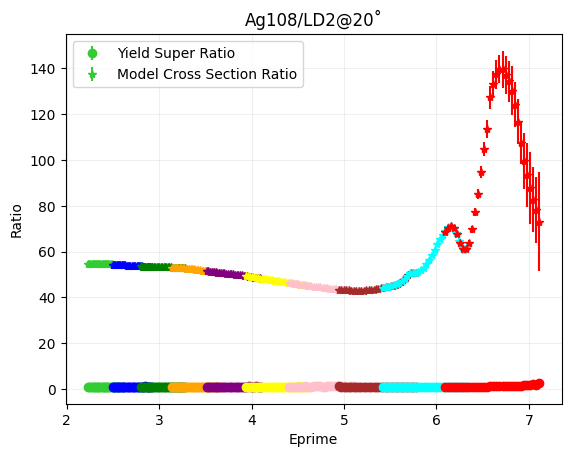

In [26]:
born_ratio_2p42 = born_xsec_array_2p42_ntg / born_xsec_array_2p42_dtg
born_ratio_2p71 = born_xsec_array_2p71_ntg / born_xsec_array_2p71_dtg
born_ratio_3p04 = born_xsec_array_3p04_ntg / born_xsec_array_3p04_dtg
born_ratio_3p4 = born_xsec_array_3p4_ntg / born_xsec_array_3p4_dtg
born_ratio_3p81 = born_xsec_array_3p81_ntg / born_xsec_array_3p81_dtg
born_ratio_4p27 = born_xsec_array_4p27_ntg / born_xsec_array_4p27_dtg
born_ratio_4p78 = born_xsec_array_4p78_ntg / born_xsec_array_4p78_dtg
born_ratio_5p36 = born_xsec_array_5p36_ntg / born_xsec_array_5p36_dtg
born_ratio_5p878 = born_xsec_array_5p878_ntg / born_xsec_array_5p878_dtg
born_ratio_6p6 = born_xsec_array_6p6_ntg / born_xsec_array_6p6_dtg

born_ratio_errors_2p42 = born_ratio_2p42 * np.sqrt((born_errors_2p42_ntg / born_xsec_array_2p42_ntg)**2 + (born_errors_2p42_dtg / born_xsec_array_2p42_dtg)**2)
born_ratio_errors_2p71 = born_ratio_2p71 * np.sqrt((born_errors_2p71_ntg / born_xsec_array_2p71_ntg)**2 + (born_errors_2p71_dtg / born_xsec_array_2p71_dtg)**2)
born_ratio_errors_3p04 = born_ratio_3p04 * np.sqrt((born_errors_3p04_ntg / born_xsec_array_3p04_ntg)**2 + (born_errors_3p04_dtg / born_xsec_array_3p04_dtg)**2)
born_ratio_errors_3p4 = born_ratio_3p4 * np.sqrt((born_errors_3p4_ntg / born_xsec_array_3p4_ntg)**2 + (born_errors_3p4_dtg / born_xsec_array_3p4_dtg)**2)
born_ratio_errors_3p81 = born_ratio_3p81 * np.sqrt((born_errors_3p81_ntg / born_xsec_array_3p81_ntg)**2 + (born_errors_3p81_dtg / born_xsec_array_3p81_dtg)**2)
born_ratio_errors_4p27 = born_ratio_4p27 * np.sqrt((born_errors_4p27_ntg / born_xsec_array_4p27_ntg)**2 + (born_errors_4p27_dtg / born_xsec_array_4p27_dtg)**2)
born_ratio_errors_4p78 = born_ratio_4p78 * np.sqrt((born_errors_4p78_ntg / born_xsec_array_4p78_ntg)**2 + (born_errors_4p78_dtg / born_xsec_array_4p78_dtg)**2)
born_ratio_errors_5p36 = born_ratio_5p36 * np.sqrt((born_errors_5p36_ntg / born_xsec_array_5p36_ntg)**2 + (born_errors_5p36_dtg / born_xsec_array_5p36_dtg)**2)
born_ratio_errors_5p878 = born_ratio_5p878 * np.sqrt((born_errors_5p878_ntg / born_xsec_array_5p878_ntg)**2 + (born_errors_5p878_dtg / born_xsec_array_5p878_dtg)**2)
born_ratio_errors_6p6 = born_ratio_6p6 * np.sqrt((born_errors_6p6_ntg / born_xsec_array_6p6_ntg)**2 + (born_errors_6p6_dtg / born_xsec_array_6p6_dtg)**2)

super_ratio_2p42 = ratio_eprime_2p42_ntg / ratio_eprime_2p42_dtg
super_ratio_2p71 = ratio_eprime_2p71_ntg / ratio_eprime_2p71_dtg
super_ratio_3p04 = ratio_eprime_3p04_ntg / ratio_eprime_3p04_dtg
super_ratio_3p4 = ratio_eprime_3p4_ntg / ratio_eprime_3p4_dtg
super_ratio_3p81 = ratio_eprime_3p81_ntg / ratio_eprime_3p81_dtg
super_ratio_4p27 = ratio_eprime_4p27_ntg / ratio_eprime_4p27_dtg
super_ratio_4p78 = ratio_eprime_4p78_ntg / ratio_eprime_4p78_dtg
super_ratio_5p36 = ratio_eprime_5p36_ntg / ratio_eprime_5p36_dtg
super_ratio_5p878 = ratio_eprime_5p878_ntg / ratio_eprime_5p878_dtg
super_ratio_6p6 = ratio_eprime_6p6_ntg / ratio_eprime_6p6_dtg

super_ratio_errors_2p42 = super_ratio_2p42 * np.sqrt((ratio_errors_2p42_ntg / ratio_eprime_2p42_ntg)**2 + (ratio_errors_2p42_dtg / ratio_eprime_2p42_dtg)**2)
super_ratio_errors_2p71 = super_ratio_2p71 * np.sqrt((ratio_errors_2p71_ntg / ratio_eprime_2p71_ntg)**2 + (ratio_errors_2p71_dtg / ratio_eprime_2p71_dtg)**2)
super_ratio_errors_3p04 = super_ratio_3p04 * np.sqrt((ratio_errors_3p04_ntg / ratio_eprime_3p04_ntg)**2 + (ratio_errors_3p04_dtg / ratio_eprime_3p04_dtg)**2)
super_ratio_errors_3p4 = super_ratio_3p4 * np.sqrt((ratio_errors_3p4_ntg / ratio_eprime_3p4_ntg)**2 + (ratio_errors_3p4_dtg / ratio_eprime_3p4_dtg)**2)
super_ratio_errors_3p81 = super_ratio_3p81 * np.sqrt((ratio_errors_3p81_ntg / ratio_eprime_3p81_ntg)**2 + (ratio_errors_3p81_dtg / ratio_eprime_3p81_dtg)**2)
super_ratio_errors_4p27 = super_ratio_4p27 * np.sqrt((ratio_errors_4p27_ntg / ratio_eprime_4p27_ntg)**2 + (ratio_errors_4p27_dtg / ratio_eprime_4p27_dtg)**2)
super_ratio_errors_4p78 = super_ratio_4p78 * np.sqrt((ratio_errors_4p78_ntg / ratio_eprime_4p78_ntg)**2 + (ratio_errors_4p78_dtg / ratio_eprime_4p78_dtg)**2)
super_ratio_errors_5p36 = super_ratio_5p36 * np.sqrt((ratio_errors_5p36_ntg / ratio_eprime_5p36_ntg)**2 + (ratio_errors_5p36_dtg / ratio_eprime_5p36_dtg)**2)
super_ratio_errors_5p878 = super_ratio_5p878 * np.sqrt((ratio_errors_5p878_ntg / ratio_eprime_5p878_ntg)**2 + (ratio_errors_5p878_dtg / ratio_eprime_5p878_dtg)**2)
super_ratio_errors_6p6 = super_ratio_6p6 * np.sqrt((ratio_errors_6p6_ntg / ratio_eprime_6p6_ntg)**2 + (ratio_errors_6p6_dtg / ratio_eprime_6p6_dtg)**2)

fig7, ax7 = plt.subplots()
# Plot all super_ratio lines first
ax7.errorbar(binned_eprime_bin_centers_2p42, super_ratio_2p42, yerr=super_ratio_errors_2p42, fmt='o', color='limegreen', label='Yield Super Ratio')
ax7.errorbar(binned_eprime_bin_centers_2p71, super_ratio_2p71, yerr=super_ratio_errors_2p71, fmt='o', color='blue')
ax7.errorbar(binned_eprime_bin_centers_3p04, super_ratio_3p04, yerr=super_ratio_errors_3p04, fmt='o', color='green')
ax7.errorbar(binned_eprime_bin_centers_3p4, super_ratio_3p4, yerr=super_ratio_errors_3p4, fmt='o', color='orange')
ax7.errorbar(binned_eprime_bin_centers_3p81, super_ratio_3p81, yerr=super_ratio_errors_3p81, fmt='o', color='purple')
ax7.errorbar(binned_eprime_bin_centers_4p27, super_ratio_4p27, yerr=super_ratio_errors_4p27, fmt='o', color='yellow')
ax7.errorbar(binned_eprime_bin_centers_4p78, super_ratio_4p78, yerr=super_ratio_errors_4p78, fmt='o', color='pink')
ax7.errorbar(binned_eprime_bin_centers_5p36, super_ratio_5p36, yerr=super_ratio_errors_5p36, fmt='o', color='brown')
ax7.errorbar(binned_eprime_bin_centers_5p878, super_ratio_5p878, yerr=super_ratio_errors_5p878, fmt='o', color='cyan')
ax7.errorbar(binned_eprime_bin_centers_6p6, super_ratio_6p6, yerr=super_ratio_errors_6p6, fmt='o', color='red')

# Plot all born_ratio lines after
ax7.errorbar(binned_eprime_bin_centers_2p42, born_ratio_2p42, yerr=born_ratio_errors_2p42, fmt='*', color='limegreen', label='Model Cross Section Ratio')
ax7.errorbar(binned_eprime_bin_centers_2p71, born_ratio_2p71, yerr=born_ratio_errors_2p71, fmt='*', color='blue')
ax7.errorbar(binned_eprime_bin_centers_3p04, born_ratio_3p04, yerr=born_ratio_errors_3p04, fmt='*', color='green')
ax7.errorbar(binned_eprime_bin_centers_3p4, born_ratio_3p4, yerr=born_ratio_errors_3p4, fmt='*', color='orange')
ax7.errorbar(binned_eprime_bin_centers_3p81, born_ratio_3p81, yerr=born_ratio_errors_3p81, fmt='*', color='purple')
ax7.errorbar(binned_eprime_bin_centers_4p27, born_ratio_4p27, yerr=born_ratio_errors_4p27, fmt='*', color='yellow')
ax7.errorbar(binned_eprime_bin_centers_4p78, born_ratio_4p78, yerr=born_ratio_errors_4p78, fmt='*', color='pink')
ax7.errorbar(binned_eprime_bin_centers_5p36, born_ratio_5p36, yerr=born_ratio_errors_5p36, fmt='*', color='brown')
ax7.errorbar(binned_eprime_bin_centers_5p878, born_ratio_5p878, yerr=born_ratio_errors_5p878, fmt='*', color='cyan')
ax7.errorbar(binned_eprime_bin_centers_6p6, born_ratio_6p6, yerr=born_ratio_errors_6p6, fmt='*', color='red')

ax7.set_xlabel('Eprime')
ax7.set_ylabel('Ratio')
ax7.set_title(f'{ntg}/{dtg}@{idang}˚')
# ax7.set_yscale('log')
ax7.grid(alpha = 0.2)
ax7.legend()
# fig7.savefig(f'{folder}/super_ratio_{dtg}_{dang}_{start_time:.0f}.png', dpi = 300)

<h1 align="center">TAKING CROSS-SECTION RATIOS</h1>

Per-nucleon scaling factor: 54.0
slope -0.08012282754550851


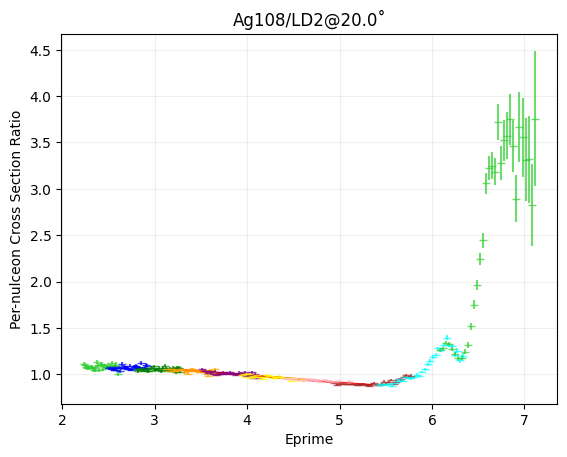

In [27]:
nA = target_info[ntg][1]
nZ = target_info[ntg][0]
dA = target_info[dtg][1]

sf = nA / dA
print("Per-nucleon scaling factor:", sf)

csr_2p42 = born_cross_2p42_ntg / born_cross_2p42_dtg / sf
csr_2p71 = born_cross_2p71_ntg / born_cross_2p71_dtg / sf
csr_3p04 = born_cross_3p04_ntg / born_cross_3p04_dtg / sf
csr_3p4 = born_cross_3p4_ntg / born_cross_3p4_dtg / sf
csr_3p81 = born_cross_3p81_ntg / born_cross_3p81_dtg / sf
csr_4p27 = born_cross_4p27_ntg / born_cross_4p27_dtg / sf
csr_4p78 = born_cross_4p78_ntg / born_cross_4p78_dtg / sf
csr_5p36 = born_cross_5p36_ntg / born_cross_5p36_dtg / sf
csr_5p878 = born_cross_5p878_ntg / born_cross_5p878_dtg / sf
csr_6p6 = born_cross_6p6_ntg / born_cross_6p6_dtg / sf

csr_errors_2p42 = csr_2p42 * np.sqrt((born_errors_2p42_ntg / born_cross_2p42_ntg)**2 + (born_errors_2p42_dtg / born_cross_2p42_dtg)**2)
csr_errors_2p71 = csr_2p71 * np.sqrt((born_errors_2p71_ntg / born_cross_2p71_ntg)**2 + (born_errors_2p71_dtg / born_cross_2p71_dtg)**2)
csr_errors_3p04 = csr_3p04 * np.sqrt((born_errors_3p04_ntg / born_cross_3p04_ntg)**2 + (born_errors_3p04_dtg / born_cross_3p04_dtg)**2)
csr_errors_3p4 = csr_3p4 * np.sqrt((born_errors_3p4_ntg / born_cross_3p4_ntg)**2 + (born_errors_3p4_dtg / born_cross_3p4_dtg)**2)
csr_errors_3p81 = csr_3p81 * np.sqrt((born_errors_3p81_ntg / born_cross_3p81_ntg)**2 + (born_errors_3p81_dtg / born_cross_3p81_dtg)**2)
csr_errors_4p27 = csr_4p27 * np.sqrt((born_errors_4p27_ntg / born_cross_4p27_ntg)**2 + (born_errors_4p27_dtg / born_cross_4p27_dtg)**2)
csr_errors_4p78 = csr_4p78 * np.sqrt((born_errors_4p78_ntg / born_cross_4p78_ntg)**2 + (born_errors_4p78_dtg / born_cross_4p78_dtg)**2)
csr_errors_5p36 = csr_5p36 * np.sqrt((born_errors_5p36_ntg / born_cross_5p36_ntg)**2 + (born_errors_5p36_dtg / born_cross_5p36_dtg)**2)
csr_errors_5p878 = csr_5p878 * np.sqrt((born_errors_5p878_ntg / born_cross_5p878_ntg)**2 + (born_errors_5p878_dtg / born_cross_5p878_dtg)**2)
csr_errors_6p6 = csr_6p6 * np.sqrt((born_errors_6p6_ntg / born_cross_6p6_ntg)**2 + (born_errors_6p6_dtg / born_cross_6p6_dtg)**2)

fig7, ax7 = plt.subplots()
ax7.errorbar(binned_eprime_bin_centers_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax7.errorbar(binned_eprime_bin_centers_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax7.errorbar(binned_eprime_bin_centers_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax7.errorbar(binned_eprime_bin_centers_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax7.errorbar(binned_eprime_bin_centers_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax7.errorbar(binned_eprime_bin_centers_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax7.errorbar(binned_eprime_bin_centers_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax7.errorbar(binned_eprime_bin_centers_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax7.errorbar(binned_eprime_bin_centers_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax7.errorbar(binned_eprime_bin_centers_6p6, csr_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax7.set_xlabel('Eprime')
ax7.set_ylabel('Per-nulceon Cross Section Ratio')
ax7.set_title(f'{ntg}/{dtg}@{dang}˚')
ax7.grid(alpha = 0.2)
# ax7.set_ylim(0.82, 1.2)
# ax7.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1.0))

csr = np.concatenate((csr_2p42, csr_2p71, csr_3p04, csr_3p4, csr_3p81, csr_4p27, csr_4p78, csr_5p36, csr_5p878, csr_6p6))
bin_centers = np.concatenate((binned_eprime_bin_centers_2p42, binned_eprime_bin_centers_2p71, binned_eprime_bin_centers_3p04, binned_eprime_bin_centers_3p4, binned_eprime_bin_centers_3p81, binned_eprime_bin_centers_4p27, binned_eprime_bin_centers_4p78, binned_eprime_bin_centers_5p36, binned_eprime_bin_centers_5p878, binned_eprime_bin_centers_6p6))
maskep = (bin_centers >= 3.23) & (bin_centers <= 5.36) & ~np.isnan(csr)
filtered_csr = csr[maskep]
filtered_bin_centers = bin_centers[maskep]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("slope", slope)
# print("high point", slope * np.max(filtered_bin_centers) + intercept)
# print("low point", slope * np.min(filtered_bin_centers) + intercept)
ax7.plot(filtered_bin_centers, slope * filtered_bin_centers + intercept, 'r')
# fig7.savefig(f'{folder}/csr_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

<h1 align="center">Converting to Bjorken-x</h1>

absolute value of slope 0.4363309364123291
EMC Ratio at x = 0.3: 1.04402830158348


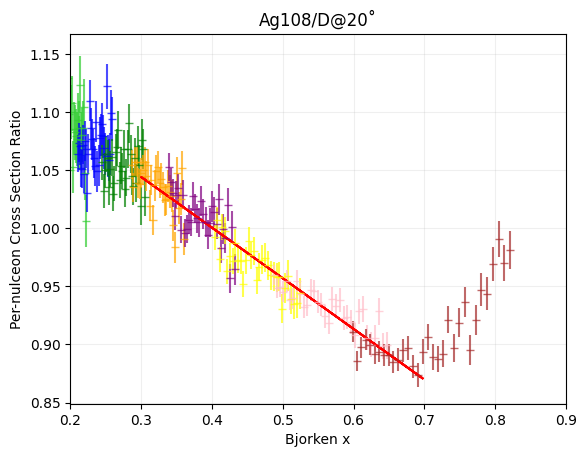

In [28]:
bin_centers_bjx_2p42 = (4 * Ei * binned_eprime_bin_centers_2p42 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_2p42))
bin_centers_bjx_2p71 = (4 * Ei * binned_eprime_bin_centers_2p71 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_2p71))
bin_centers_bjx_3p04 = (4 * Ei * binned_eprime_bin_centers_3p04 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_3p04))
bin_centers_bjx_3p4 = (4 * Ei * binned_eprime_bin_centers_3p4 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_3p4))
bin_centers_bjx_3p81 = (4 * Ei * binned_eprime_bin_centers_3p81 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_3p81))
bin_centers_bjx_4p27 = (4 * Ei * binned_eprime_bin_centers_4p27 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_4p27))
bin_centers_bjx_4p78 = (4 * Ei * binned_eprime_bin_centers_4p78 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_4p78))
bin_centers_bjx_5p36 = (4 * Ei * binned_eprime_bin_centers_5p36 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_5p36))
bin_centers_bjx_5p878 = (4 * Ei * binned_eprime_bin_centers_5p878 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_5p878))
bin_centers_bjx_6p6 = (4 * Ei * binned_eprime_bin_centers_6p6 * np.sin(dang * np.pi / 180 / 2)**2) / (2 * Mp * (Ei - binned_eprime_bin_centers_6p6))

fig8, ax8 = plt.subplots()
ax8.errorbar(bin_centers_bjx_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax8.errorbar(bin_centers_bjx_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax8.errorbar(bin_centers_bjx_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax8.errorbar(bin_centers_bjx_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax8.errorbar(bin_centers_bjx_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax8.errorbar(bin_centers_bjx_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax8.errorbar(bin_centers_bjx_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax8.errorbar(bin_centers_bjx_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
# ax8.errorbar(bin_centers_bjx_5p878, csr_5p878, yerr = csr_errors_5p878, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
# ax8.errorbar(bin_centers_bjx_6p6, csr_6p6, yerr = csr_errors_6p6, fmt = '_', alpha = 0.7, color = 'limegreen', label = '6.6 GeV')
ax8.set_xlabel('Bjorken x')
ax8.set_ylabel('Per-nulceon Cross Section Ratio')
ax8.set_title(f'{ntg}/D@{idang}˚')
# ax8.set_ylim(0.75, 1.1)
ax8.set_xlim(0.2, 0.9)
ax8.grid(alpha = 0.2)

bjx_bin_centers = np.concatenate((bin_centers_bjx_2p42, bin_centers_bjx_2p71, bin_centers_bjx_3p04, bin_centers_bjx_3p4, bin_centers_bjx_3p81, bin_centers_bjx_4p27, bin_centers_bjx_4p78, bin_centers_bjx_5p36, bin_centers_bjx_5p878, bin_centers_bjx_6p6))
mask = (bjx_bin_centers >= fit_lo) & (bjx_bin_centers <= fit_high) & ~np.isnan(csr)
filtered_bin_centers = bjx_bin_centers[mask]
filtered_csr = csr[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_bin_centers, filtered_csr)
print("absolute value of slope", abs(slope))
print("EMC Ratio at x = 0.3:", slope * np.min(filtered_bin_centers) + intercept)
_  = ax8.plot(filtered_bin_centers, slope * filtered_bin_centers + intercept, 'r')
# fig8.savefig(f'{folder}/emc_{ntg}_{dtg}_{dang}_{start_time:.0f}.pdf')

In [29]:
born_ratio = np.concatenate((born_ratio_2p42, born_ratio_2p71, born_ratio_3p04, born_ratio_3p4, born_ratio_3p81, born_ratio_4p27, born_ratio_4p78, born_ratio_5p36, born_ratio_5p878, born_ratio_6p6))
born_error = np.concatenate((born_ratio_errors_2p42, born_ratio_errors_2p71, born_ratio_errors_3p04, born_ratio_errors_3p4, born_ratio_errors_3p81, born_ratio_errors_4p27, born_ratio_errors_4p78, born_ratio_errors_5p36, born_ratio_errors_5p878, born_ratio_errors_6p6))

pernucleon_born_ratio = born_ratio / sf
pernucleon_born_error = born_error / sf

# 
ax8.errorbar(bjx_bin_centers[bjx_bin_centers < 0.9], pernucleon_born_ratio[bjx_bin_centers < 0.9], yerr = pernucleon_born_error[bjx_bin_centers < 0.9], fmt = '_', alpha = 0.4, color = 'gold', label = 'Born Cross Section Ratio')

filtered_born_ratio = pernucleon_born_ratio[mask]
model_slope, model_intercept, model_r_value, model_p_value, model_std_err = stats.linregress(filtered_bin_centers, filtered_born_ratio)
ax8.plot(filtered_bin_centers, model_slope * filtered_bin_centers + model_intercept, 'r')

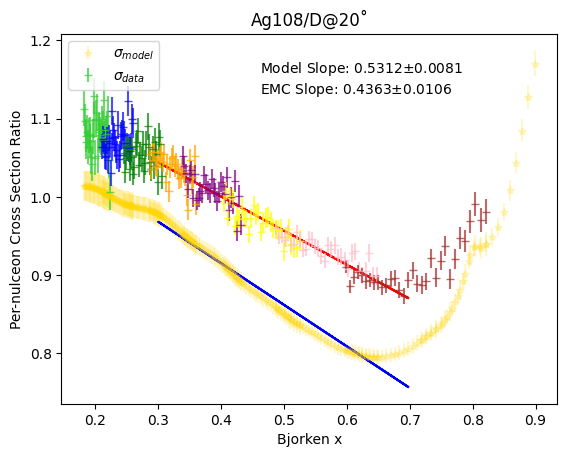

In [30]:
fig9, ax9 = plt.subplots()
ax9.errorbar(bjx_bin_centers[bjx_bin_centers < 0.9], pernucleon_born_ratio[bjx_bin_centers < 0.9], yerr = pernucleon_born_error[bjx_bin_centers < 0.9], fmt = '*', alpha = 0.2, color = 'gold', label = r'$\sigma_{model}$')
ax9.plot(filtered_bin_centers, model_slope * filtered_bin_centers + model_intercept, 'b')
ax9.plot(filtered_bin_centers, slope * filtered_bin_centers + intercept, 'r')
ax9.errorbar(bin_centers_bjx_2p42, csr_2p42, yerr = csr_errors_2p42, fmt = '_', alpha = 0.7, color = 'limegreen', label = r'$\sigma_{data}$')
ax9.errorbar(bin_centers_bjx_2p71, csr_2p71, yerr = csr_errors_2p71, fmt = '_', alpha = 0.7, color = 'blue')
ax9.errorbar(bin_centers_bjx_3p04, csr_3p04, yerr = csr_errors_3p04, fmt = '_', alpha = 0.7, color = 'green')
ax9.errorbar(bin_centers_bjx_3p4, csr_3p4, yerr = csr_errors_3p4, fmt = '_', alpha = 0.7, color = 'orange')
ax9.errorbar(bin_centers_bjx_3p81, csr_3p81, yerr = csr_errors_3p81, fmt = '_', alpha = 0.7, color = 'purple')
ax9.errorbar(bin_centers_bjx_4p27, csr_4p27, yerr = csr_errors_4p27, fmt = '_', alpha = 0.7, color = 'yellow')
ax9.errorbar(bin_centers_bjx_4p78, csr_4p78, yerr = csr_errors_4p78, fmt = '_', alpha = 0.7, color = 'pink')
ax9.errorbar(bin_centers_bjx_5p36, csr_5p36, yerr = csr_errors_5p36, fmt = '_', alpha = 0.7, color = 'brown')
ax9.set_xlabel('Bjorken x')
ax9.set_ylabel('Per-nulceon Cross Section Ratio')
ax9.set_title(f'{ntg}/D@{idang}˚')
ax9.legend()
ax9.text(0.4, 0.79, f'Model Slope: {abs(model_slope):.4f}$\pm${model_std_err:.4f} \nEMC Slope: {abs(slope):.4f}$\pm${std_err:.4f} \n', transform = ax9.transAxes)
fig9.savefig(f'{folder}/emcdatamodel_{ntg}_{dtg}_{dang}_{start_time:.0f}.png', dpi = 300)
# with open(f'{folder}/emcmodelslopes.txt', 'a') as f:
#     f.write(f'Model Slope {ntg}: {abs(model_slope):.4f}$\pm${model_std_err:.4f} \nEMC Slope {ntg}: {abs(slope):.4f}$\pm${std_err:.4f} \n')

# Calculating isoscalar correction factor

In [31]:
all_eprime_bin_centers = np.concatenate((binned_eprime_bin_centers_2p42, binned_eprime_bin_centers_2p71, binned_eprime_bin_centers_3p04, binned_eprime_bin_centers_3p4, binned_eprime_bin_centers_3p81, binned_eprime_bin_centers_4p27, binned_eprime_bin_centers_4p78, binned_eprime_bin_centers_5p36, binned_eprime_bin_centers_5p878, binned_eprime_bin_centers_6p6))
all_bjx = np.concatenate((bin_centers_bjx_2p42, bin_centers_bjx_2p71, bin_centers_bjx_3p04, bin_centers_bjx_3p4, bin_centers_bjx_3p81, bin_centers_bjx_4p27, bin_centers_bjx_4p78, bin_centers_bjx_5p36, bin_centers_bjx_5p878, bin_centers_bjx_6p6))
isoscalar_all = np.zeros(len(all_eprime_bin_centers))
q2_all = 4 * Ei * all_eprime_bin_centers * (np.sin(dang * np.pi / 180 / 2))**2
print(f"The minimum and maximum Q^2 values are {np.min(q2_all):.2f} and {np.max(q2_all):.2f}")

for i in range(len(all_eprime_bin_centers)):
    isoscalar_all[i] = jra_nprat(all_bjx[i], q2_all[i])

print("Average of q2_all", np.mean(q2_all))
print("Average of Bjorken x", np.mean(all_bjx))
print("Length and average of isoscalar_all", len(isoscalar_all), np.mean(isoscalar_all))

# a = plt.plot(all_bjx[isoscalar_all != 1], isoscalar_all[isoscalar_all != 1], '_', alpha = 0.7, color = 'blue')
# plt.xlabel('Bjorken x')
# plt.ylabel(r'$F^2_n/F^2_p$')
# plt.grid(alpha = 0.2)

The minimum and maximum Q^2 values are 2.84 and 9.04
Average of q2_all 5.37344441814154
Average of Bjorken x 0.5154990242004842
Length and average of isoscalar_all 320 0.5993698323405449


\begin{equation}
    \text{isoscalar all} = \frac{\sigma_n}{\sigma_p}
\end{equation}

# Calculating and Plotting the final Cross-Section Ratios

\begin{equation}
    \left( \frac{\sigma_A}{\sigma_D} \right)_{\text{ISO}} = \frac{A}{2} \left( \frac{1 + \frac{\sigma_n}{\sigma_p}}{Z + N \frac{\sigma_n}{\sigma_p}} \right) \frac{\sigma_A}{\sigma_D},
\end{equation}

\begin{equation}
    \text{isoscalar factor} = \frac{A}{2} \left( \frac{1 + \frac{\sigma_n}{\sigma_p}}{Z + N \frac{\sigma_n}{\sigma_p}} \right)
\end{equation}

nN 61
nZ 47
nA 108
Mean of isoscalar_factor 1.0363501912964102


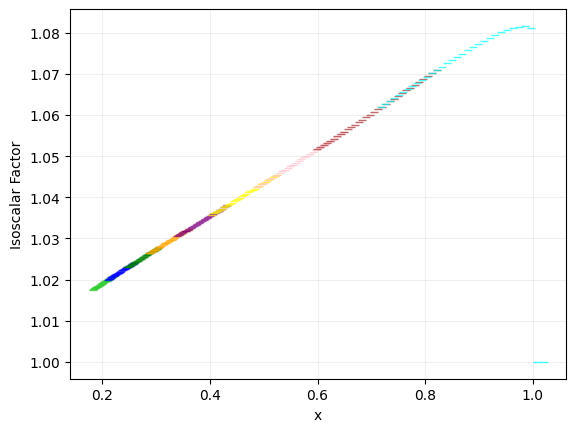

In [32]:
nN = nA - nZ
print("nN", nN)
print("nZ", nZ)
print("nA", nA)

isoscalar_factor = (nA/2 * (1 + isoscalar_all))/(nZ + (nN * isoscalar_all))
isoscalar_factor_2p42 = isoscalar_factor[0:len(binned_eprime_bin_centers_2p42)]
isoscalar_factor_2p71 = isoscalar_factor[len(binned_eprime_bin_centers_2p42):2 * len(binned_eprime_bin_centers_2p71)]
isoscalar_factor_3p04 = isoscalar_factor[2 * len(binned_eprime_bin_centers_2p71):3 * len(binned_eprime_bin_centers_3p04)]
isoscalar_factor_3p4 = isoscalar_factor[3 * len(binned_eprime_bin_centers_3p04):4 * len(binned_eprime_bin_centers_3p4)]
isoscalar_factor_3p81 = isoscalar_factor[4 * len(binned_eprime_bin_centers_3p4):5 * len(binned_eprime_bin_centers_3p81)]
isoscalar_factor_4p27 = isoscalar_factor[5 * len(binned_eprime_bin_centers_3p81):6 * len(binned_eprime_bin_centers_4p27)]
isoscalar_factor_4p78 = isoscalar_factor[6 * len(binned_eprime_bin_centers_4p27):7 * len(binned_eprime_bin_centers_4p78)]
isoscalar_factor_5p36 = isoscalar_factor[7 * len(binned_eprime_bin_centers_4p78):8 * len(binned_eprime_bin_centers_5p36)]
isoscalar_factor_5p878 = isoscalar_factor[8 * len(binned_eprime_bin_centers_5p36):9 * len(binned_eprime_bin_centers_5p878)]
isoscalar_factor_6p6 = isoscalar_factor[9 * len(binned_eprime_bin_centers_5p878):10 * len(binned_eprime_bin_centers_6p6)]
print("Mean of isoscalar_factor", np.mean(isoscalar_factor))

# Apply isoscalar correction to cross-section ratios
iso_csr_2p42 = csr_2p42 * isoscalar_factor_2p42
iso_csr_2p71 = csr_2p71 * isoscalar_factor_2p71
iso_csr_3p04 = csr_3p04 * isoscalar_factor_3p04
iso_csr_3p4 = csr_3p4 * isoscalar_factor_3p4
iso_csr_3p81 = csr_3p81 * isoscalar_factor_3p81
iso_csr_4p27 = csr_4p27 * isoscalar_factor_4p27
iso_csr_4p78 = csr_4p78 * isoscalar_factor_4p78
iso_csr_5p36 = csr_5p36 * isoscalar_factor_5p36
iso_csr_5p878 = csr_5p878 * isoscalar_factor_5p878
iso_csr_6p6 = csr_6p6 * isoscalar_factor_6p6

plt.plot(bin_centers_bjx_2p42, isoscalar_factor_2p42, '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
plt.plot(bin_centers_bjx_2p71, isoscalar_factor_2p71, '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
plt.plot(bin_centers_bjx_3p04, isoscalar_factor_3p04, '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
plt.plot(bin_centers_bjx_3p4, isoscalar_factor_3p4, '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
plt.plot(bin_centers_bjx_3p81, isoscalar_factor_3p81, '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
plt.plot(bin_centers_bjx_4p27, isoscalar_factor_4p27, '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
plt.plot(bin_centers_bjx_4p78, isoscalar_factor_4p78, '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
plt.plot(bin_centers_bjx_5p36, isoscalar_factor_5p36, '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
plt.plot(bin_centers_bjx_5p878, isoscalar_factor_5p878, '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
plt.grid(alpha = 0.2)
plt.xlabel('x')
_ = plt.ylabel('Isoscalar Factor')

Value of isoscalar corrected slope -0.3759300207537139
EMC Ratio at x = 0.3: 1.073297334392545


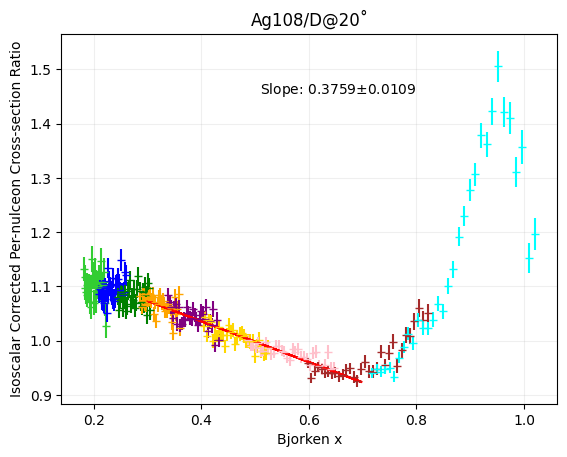

In [33]:
fig9, ax9 = plt.subplots()
ax9.errorbar(bin_centers_bjx_2p42, iso_csr_2p42, yerr = isoscalar_factor_2p42 * csr_errors_2p42, fmt = '_', color = 'limegreen', label = '2.42 GeV')
ax9.errorbar(bin_centers_bjx_2p71, iso_csr_2p71, yerr = isoscalar_factor_2p71 * csr_errors_2p71, fmt = '_', color = 'blue', label = '2.71 GeV')
ax9.errorbar(bin_centers_bjx_3p04, iso_csr_3p04, yerr = isoscalar_factor_3p04 * csr_errors_3p04, fmt = '_', color = 'green', label = '3.04 GeV')
ax9.errorbar(bin_centers_bjx_3p4, iso_csr_3p4, yerr = isoscalar_factor_3p4 * csr_errors_3p4, fmt = '_', color = 'orange', label = '3.4 GeV')
ax9.errorbar(bin_centers_bjx_3p81, iso_csr_3p81, yerr = isoscalar_factor_3p81 * csr_errors_3p81, fmt = '_', color = 'purple', label = '3.81 GeV')
ax9.errorbar(bin_centers_bjx_4p27, iso_csr_4p27, yerr = isoscalar_factor_4p27 * csr_errors_4p27, fmt = '_', color = 'gold', label = '4.27 GeV')
ax9.errorbar(bin_centers_bjx_4p78, iso_csr_4p78, yerr = isoscalar_factor_4p78 * csr_errors_4p78, fmt = '_', color = 'pink', label = '4.78 GeV')
ax9.errorbar(bin_centers_bjx_5p36, iso_csr_5p36, yerr = isoscalar_factor_5p36 * csr_errors_5p36, fmt = '_', color = 'brown', label = '5.36 GeV')
ax9.errorbar(bin_centers_bjx_5p878, iso_csr_5p878, yerr = isoscalar_factor_5p878 * csr_errors_5p878, fmt = '_', color = 'cyan', label = '5.878 GeV')
# ax9.errorbar(bin_centers_bjx_6p6, iso_csr_6p6, yerr = isoscalar_factor_6p6 * csr_errors_6p6, fmt = '_', color = 'limegreen', label = '6.6 GeV')

ax9.set_xlabel('Bjorken x')
# ax9.set_ylabel(fr'$\sigma_{ntg}$/{nA}/$\sigma_D$/2@{dang}˚')
ax9.set_ylabel('Isoscalar Corrected Per-nulceon Cross-section Ratio')
ax9.set_title(f'{ntg}/D@{idang}˚')
ax9.grid(alpha = 0.2)
# ax9.legend()

iso_csr = np.concatenate((iso_csr_2p42, iso_csr_2p71, iso_csr_3p04, iso_csr_3p4, iso_csr_3p81, iso_csr_4p27, iso_csr_4p78, iso_csr_5p36, iso_csr_5p878, iso_csr_6p6))
bin_centers = np.concatenate((bin_centers_bjx_2p42, bin_centers_bjx_2p71, bin_centers_bjx_3p04, bin_centers_bjx_3p4, bin_centers_bjx_3p81, bin_centers_bjx_4p27, bin_centers_bjx_4p78, bin_centers_bjx_5p36, bin_centers_bjx_5p878, bin_centers_bjx_6p6))
bin_errors = np.concatenate((isoscalar_factor_2p42 * csr_errors_2p42, isoscalar_factor_2p71 * csr_errors_2p71, isoscalar_factor_3p04 * csr_errors_3p04, isoscalar_factor_3p4 * csr_errors_3p4, isoscalar_factor_3p81 * csr_errors_3p81, isoscalar_factor_4p27 * csr_errors_4p27, isoscalar_factor_4p78 * csr_errors_4p78, isoscalar_factor_5p36 * csr_errors_5p36, isoscalar_factor_5p878 * csr_errors_5p878, isoscalar_factor_6p6 * csr_errors_6p6))
filtered_iso_csr = iso_csr[mask]

iso_slope, iso_intercept, iso_r_value, iso_p_value, iso_std_err = stats.linregress(filtered_bin_centers, filtered_iso_csr)
print("Value of isoscalar corrected slope", iso_slope)
norm_3 = iso_slope * np.min(filtered_bin_centers) + iso_intercept
# print("Error on slope", iso_std_err)
print("EMC Ratio at x = 0.3:", norm_3)
ax9.plot(filtered_bin_centers, iso_slope * filtered_bin_centers + iso_intercept, 'r')
# ax9.set_ylim(0.6, 0.9)
# ax9.set_xlim(0.15, 1.0)
ax9.text(0.4, 0.79, f'Slope: {abs(iso_slope):.4f}$\pm${iso_std_err:.4f} \n', transform = ax9.transAxes)
fig9.savefig(f'{folder}/isoscalarcorrected_emc_{ntg}_{idang}_{start_time:.0f}.png', dpi = 300)

# Write the final cross-section ratios to a file

In [34]:
filepath = f"{folder}/csr_{ntg}_{dtg}_{idang}.txt"
with open(filepath, "w") as file:
    for i in range(len(bin_centers)):
        file.write(f"{bin_centers[i]}\t{iso_csr[i]}\t{bin_errors[i]}\n")

pymodule = f"{folder}/{ntg}_{idang}.py"
# with open(pymodule, "w") as f:
#     f.write(f'bjx_bin_centers = {bin_centers.tolist()}')


In [35]:
minutes = (time.time() - start_time) / 60
print(f"Time taken: {minutes:.2f} minutes")
# baja()

Time taken: 5.31 minutes
